##Required imports

In [2]:
!pip install einops


In [3]:
!pip install -q open_clip_torch
import open_clip

c:\Users\user\Desktop\CrossHL-VLM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

import sys, os
sys.path.append(os.getcwd())

import sys
sys.path.append("./../")
import os
import numpy as np
import random
from torch import einsum
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.utils.data as dataf
from torch.utils.data import Dataset
from scipy import io
from scipy.io import loadmat as loadmat
from sklearn.decomposition import PCA
from torch.nn.parameter import Parameter
import torchvision.transforms.functional as TF
from torch.nn import LayerNorm,Linear,Dropout,Softmax
import time
from PIL import Image
import math
from operator import truediv
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import re
from pathlib import Path
import copy
import open_clip
from torch.utils.data import Subset
from sklearn.manifold import TSNE
import seaborn as sns

import utils
import logger

cudnn.deterministic = True
cudnn.benchmark = False

# Dataset

In [5]:
class HSI_LiDAR_DatasetTrain(torch.utils.data.Dataset):
    def __init__(self, dataset='Trento'):

        HSI = loadmat(f'./{dataset}11x11/HSI_Tr.mat')
        LiDAR = loadmat(f'./{dataset}11x11/LIDAR_Tr.mat')
        label = loadmat(f'./{dataset}11x11/TrLabel.mat')

        self.hs_image = (torch.from_numpy(HSI['Data'].astype(np.float32)).to(torch.float32)).permute(0,3,1,2)
        self.lidar_image = (torch.from_numpy(LiDAR['Data'].astype(np.float32)).to(torch.float32)).permute(0,3,1,2)
        self.lbls = ((torch.from_numpy(label['Data'])-1).long()).reshape(-1)

    def __len__(self):
        return self.hs_image.shape[0]

    def __getitem__(self, i):
        return self.hs_image[i], self.lidar_image[i], self.lbls[i]

class HSI_LiDAR_DatasetTest(torch.utils.data.Dataset):
    def __init__(self, dataset='Trento'):

        HSI = loadmat(f'./{dataset}11x11/HSI_Te.mat')
        LiDAR = loadmat(f'./{dataset}11x11/LIDAR_Te.mat')
        label = loadmat(f'./{dataset}11x11/TeLabel.mat')

        self.hs_image = (torch.from_numpy(HSI['Data'].astype(np.float32)).to(torch.float32)).permute(0,3,1,2)
        self.lidar_image = (torch.from_numpy(LiDAR['Data'].astype(np.float32)).to(torch.float32)).permute(0,3,1,2)
        self.lbls = ((torch.from_numpy(label['Data'])-1).long()).reshape(-1)


    def __len__(self):
        return self.hs_image.shape[0]

    def __getitem__(self, i):
        return self.hs_image[i], self.lidar_image[i], self.lbls[i]

In [6]:
def make_fewshot_subset(dataset, pct=0.01, seed=14):  #enforces class-balanced few-shot
    g = torch.Generator().manual_seed(seed)
    labels = dataset.lbls.cpu()
    indices = torch.arange(len(labels))
    selected = []
    for c in torch.unique(labels):
        cls_idx = indices[labels == c]
        n = len(cls_idx)
        k = max(1, int(round(pct * n)))
        perm = cls_idx[torch.randperm(n, generator=g)]
        selected.append(perm[:k])
    selected = torch.cat(selected).tolist()
    return Subset(dataset, selected)  #returns a Subset so the rest of the pipeline stays unchanged

# Cross-HL Model

In [7]:
class HetConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,padding = None, bias = None,p = 64, g = 64):
        super(HetConv, self).__init__()
        # Groupwise Convolution
        self.groupwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,groups=g,padding = kernel_size//3, stride = stride)
        # Pointwise Convolution
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1,groups=p, stride = stride)
    def forward(self, x):
        return self.groupwise_conv(x) + self.pointwise_conv(x)



# Cross-HL Attention Module
class CrossHL_attention(nn.Module):
    def __init__(self, dim, patches, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.1, proj_drop=0.1):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.dim = dim
        self.Wq = nn.Linear(patches, dim * num_heads , bias=qkv_bias)
        self.Wk = nn.Linear(dim, dim , bias=qkv_bias)
        self.Wv = nn.Linear(patches+1, dim , bias=qkv_bias)
        self.linear_projection = nn.Linear(dim * num_heads, dim)
        self.linear_projection_drop = nn.Dropout(proj_drop)

    def forward(self, x, x2):

        B, N, C = x.shape
        # query vector using lidar data
        query = self.Wq(x2).reshape(B, self.num_heads, self.num_heads, self.dim // self.num_heads).permute(0, 1, 2, 3)

        key = self.Wk(x).reshape(B, N, self.num_heads, self.dim // self.num_heads).permute(0, 2, 1, 3)
        value = self.Wv(x.transpose(1,2)).reshape(B, C, self.num_heads, self.dim // self.num_heads).permute(0, 2, 3, 1)
        attention = torch.einsum('bhid,bhjd->bhij', key, query) * self.scale
        attention = attention.softmax(dim=-1)

        x = torch.einsum('bhij,bhjd->bhid', attention, value)
        x = x.reshape(B, N, -1)
        x = self.linear_projection(x)
        x = self.linear_projection_drop(x)
        return x

class MultiLayerPerceptron(nn.Module):
  def __init__(self, dim, mlp_dim):
        super().__init__()
        self.fclayer1 = Linear(dim, mlp_dim)
        self.fclayer2 = Linear(mlp_dim, dim)
        self.act_fn = nn.GELU()
        self.dropout = Dropout(0.1)
        self._init_weights()

  def _init_weights(self):

      nn.init.xavier_uniform_(self.fclayer1.weight)
      nn.init.xavier_uniform_(self.fclayer2.weight)

      nn.init.normal_(self.fclayer1.bias, std=1e-6)
      nn.init.normal_(self.fclayer2.bias, std=1e-6)

  def forward(self, x):
      x = self.fclayer1(x)
      x = self.act_fn(x)
      x = self.dropout(x)
      x = self.fclayer2(x)
      x = self.dropout(x)
      return x


# Code for Single Encoder block contains both cross-hl attention and mlp layer
class SingleEncoderBlock(nn.Module):
    def __init__(self,dim, num_heads, mlp_dim):
        super().__init__()
        self.attention_norm = LayerNorm(dim, eps=1e-6) # First LayerNorm layer
        self.ffn_norm = LayerNorm(dim, eps=1e-6) # Second LayerNorm layer

        self.ffn = MultiLayerPerceptron(dim, mlp_dim) # MLP layer
        self.cross_hl_attention = CrossHL_attention(dim = dim, patches = 11**2) # Cross-HL Attention layer
    def forward(self, x1,x2):
        res = x1
        x = self.attention_norm(x1)
        x= self.cross_hl_attention(x,x2)
        x = x + res
        res = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + res
        return x

# Code for Multiple Encoder blocks
class Encoder(nn.Module):

    def __init__(self, dim, num_heads=8, mlp_dim=512, depth=2):
        super().__init__()
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(dim, eps=1e-6)
        for _ in range(depth):
            layer = SingleEncoderBlock(dim, num_heads, mlp_dim)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, x,x2):
        for layer_block in self.layer:
            x = layer_block(x,x2)
        encoded = self.encoder_norm(x)


        return encoded[:,0] # Selecting only the first row of each batch since it is the cls token 
                            # return cls token


class CrossHL_Transformer(nn.Module):
    def __init__(self, FM, NC, NCLidar, Classes,patchsize):
        super(CrossHL_Transformer, self).__init__()
        self.patchsize = patchsize
        self.NCLidar = NCLidar
        self.conv5 = nn.Sequential(
            nn.Conv3d(1, 8, (9, 3, 3), padding=(0,1,1), stride = 1),
            nn.BatchNorm3d(8),
            nn.ReLU()
        )

        self.hetconv_layer = nn.Sequential(
            HetConv(8 * (NC - 8), FM*4,
                p = 1,
                g = (FM*4)//4 if (8 * (NC - 8))%FM == 0 else (FM*4)//8,
                   ),
            nn.BatchNorm2d(FM*4),
            nn.ReLU()
        )

        self.ca = Encoder(FM*4)  #produces cls features, added a small projection head to map them to CLIP embedding space (512-D).
        self.fclayer = nn.Linear(FM*4 , Classes)
        self.vlm_dim = 512
        self.vlm_proj = nn.Sequential(
            nn.Linear(FM*4, FM*4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(FM*4, self.vlm_dim), #used to compute a regularization loss
        )
        


        self.position_embeddings = nn.Parameter(torch.randn(1, (patchsize**2) + 1, FM*4))
        self.dropout = nn.Dropout(0.1)
        torch.nn.init.xavier_uniform_(self.fclayer.weight)
        torch.nn.init.normal_(self.fclayer.bias, std=1e-6)
        # randomly initialized cls token
        self.clsTok = nn.Parameter(torch.zeros(1, 1, FM*4))


    def forward(self, x1, x2, return_embed=False):
        x1 = x1.reshape(x1.shape[0],-1,self.patchsize,self.patchsize)
        x2 = x2.reshape(x1.shape[0],-1,self.patchsize*self.patchsize)
        x1 = x1.unsqueeze(1)
        if(x2.shape[1] > 0):
            x2 = F.adaptive_avg_pool1d(x2.flatten(2).transpose(1,2),1).transpose(1,2).reshape(x1.shape[0],-1,self.patchsize*self.patchsize)
        x1 = self.conv5(x1)
        x1 = x1.reshape(x1.shape[0],-1,self.patchsize,self.patchsize)

        x1 = self.hetconv_layer(x1)
        x1 = x1.flatten(2)

        x1 = x1.transpose(-1, -2)
        cls_tokens = self.clsTok.expand(x1.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x1), dim = 1)
        x = x + self.position_embeddings
        x = self.dropout(x)

        cls = self.ca(x, x2)                 # [B, FM*4]
        logits = self.fclayer(cls)           # [B, Classes]

        if return_embed:
            img_embed = F.normalize(self.vlm_proj(cls), dim=-1)  # [B, 512] #Into CLS token projection 
            return logits, img_embed  #Normal head outputs class logits and uses cross-entropy
        return logits


## Model Summary (for Trento Dataset)

In [8]:
model = CrossHL_Transformer(FM=16, NC=63, NCLidar=1, Classes=6,patchsize = 11)
summary(model, [(63, 11**2),(1,11**2)]) # summary(model, [(NC, patchsize**2),(NCLidar,patchsize**2)])
print(hasattr(model, "vlm_proj"), model.vlm_proj if hasattr(model,"vlm_proj") else None)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 55, 11, 11]             656
       BatchNorm3d-2        [-1, 8, 55, 11, 11]              16
              ReLU-3        [-1, 8, 55, 11, 11]               0
            Conv2d-4           [-1, 64, 11, 11]          31,744
            Conv2d-5           [-1, 64, 11, 11]          28,224
           HetConv-6           [-1, 64, 11, 11]               0
       BatchNorm2d-7           [-1, 64, 11, 11]             128
              ReLU-8           [-1, 64, 11, 11]               0
           Dropout-9              [-1, 122, 64]               0
        LayerNorm-10              [-1, 122, 64]             128
           Linear-11               [-1, 1, 512]          61,952
           Linear-12              [-1, 122, 64]           4,096
           Linear-13               [-1, 64, 64]           7,808
           Linear-14              [-1, 

# Model Training

---------------------------------- Details for Trento dataset---------------------------------------------



### Few-shot setting: 1% labels | Train samples: 8 ###


---> Starting Experiment: BASELINE | Tag: baseline_pct1_lam0.0
Iter 1/1 | HS bands: 63, LiDAR channels: 1, Classes: 6
Epoch 9 | CE loss=0.6355 | Sem loss=0.0000 | test acc=31.28
Epoch 19 | CE loss=0.1151 | Sem loss=0.0000 | test acc=9.93
Epoch 29 | CE loss=0.0309 | Sem loss=0.0000 | test acc=11.22
Epoch 39 | CE loss=0.0041 | Sem loss=0.0000 | test acc=35.87
Epoch 49 | CE loss=0.0026 | Sem loss=0.0000 | test acc=73.95
Train time (s): 154.36909556388855
Overall Accuracy (baseline_pct1_lam0.0) = 73.95

---> Starting Experiment: NAME | Tag: name_pct1_lam0.03
Iter 1/1 | HS bands: 63, LiDAR channels: 1, Classes: 6
Epoch 9 | CE loss=0.6347 | Sem loss=0.9658 | test acc=31.26
Epoch 19 | CE loss=0.1155 | Sem loss=0.9240 | test acc=9.97
Epoch 29 | CE loss=0.0307 | Sem loss=0.9014 | test acc=11.23
Epoch 39 | CE loss=0.0043 | Sem loss

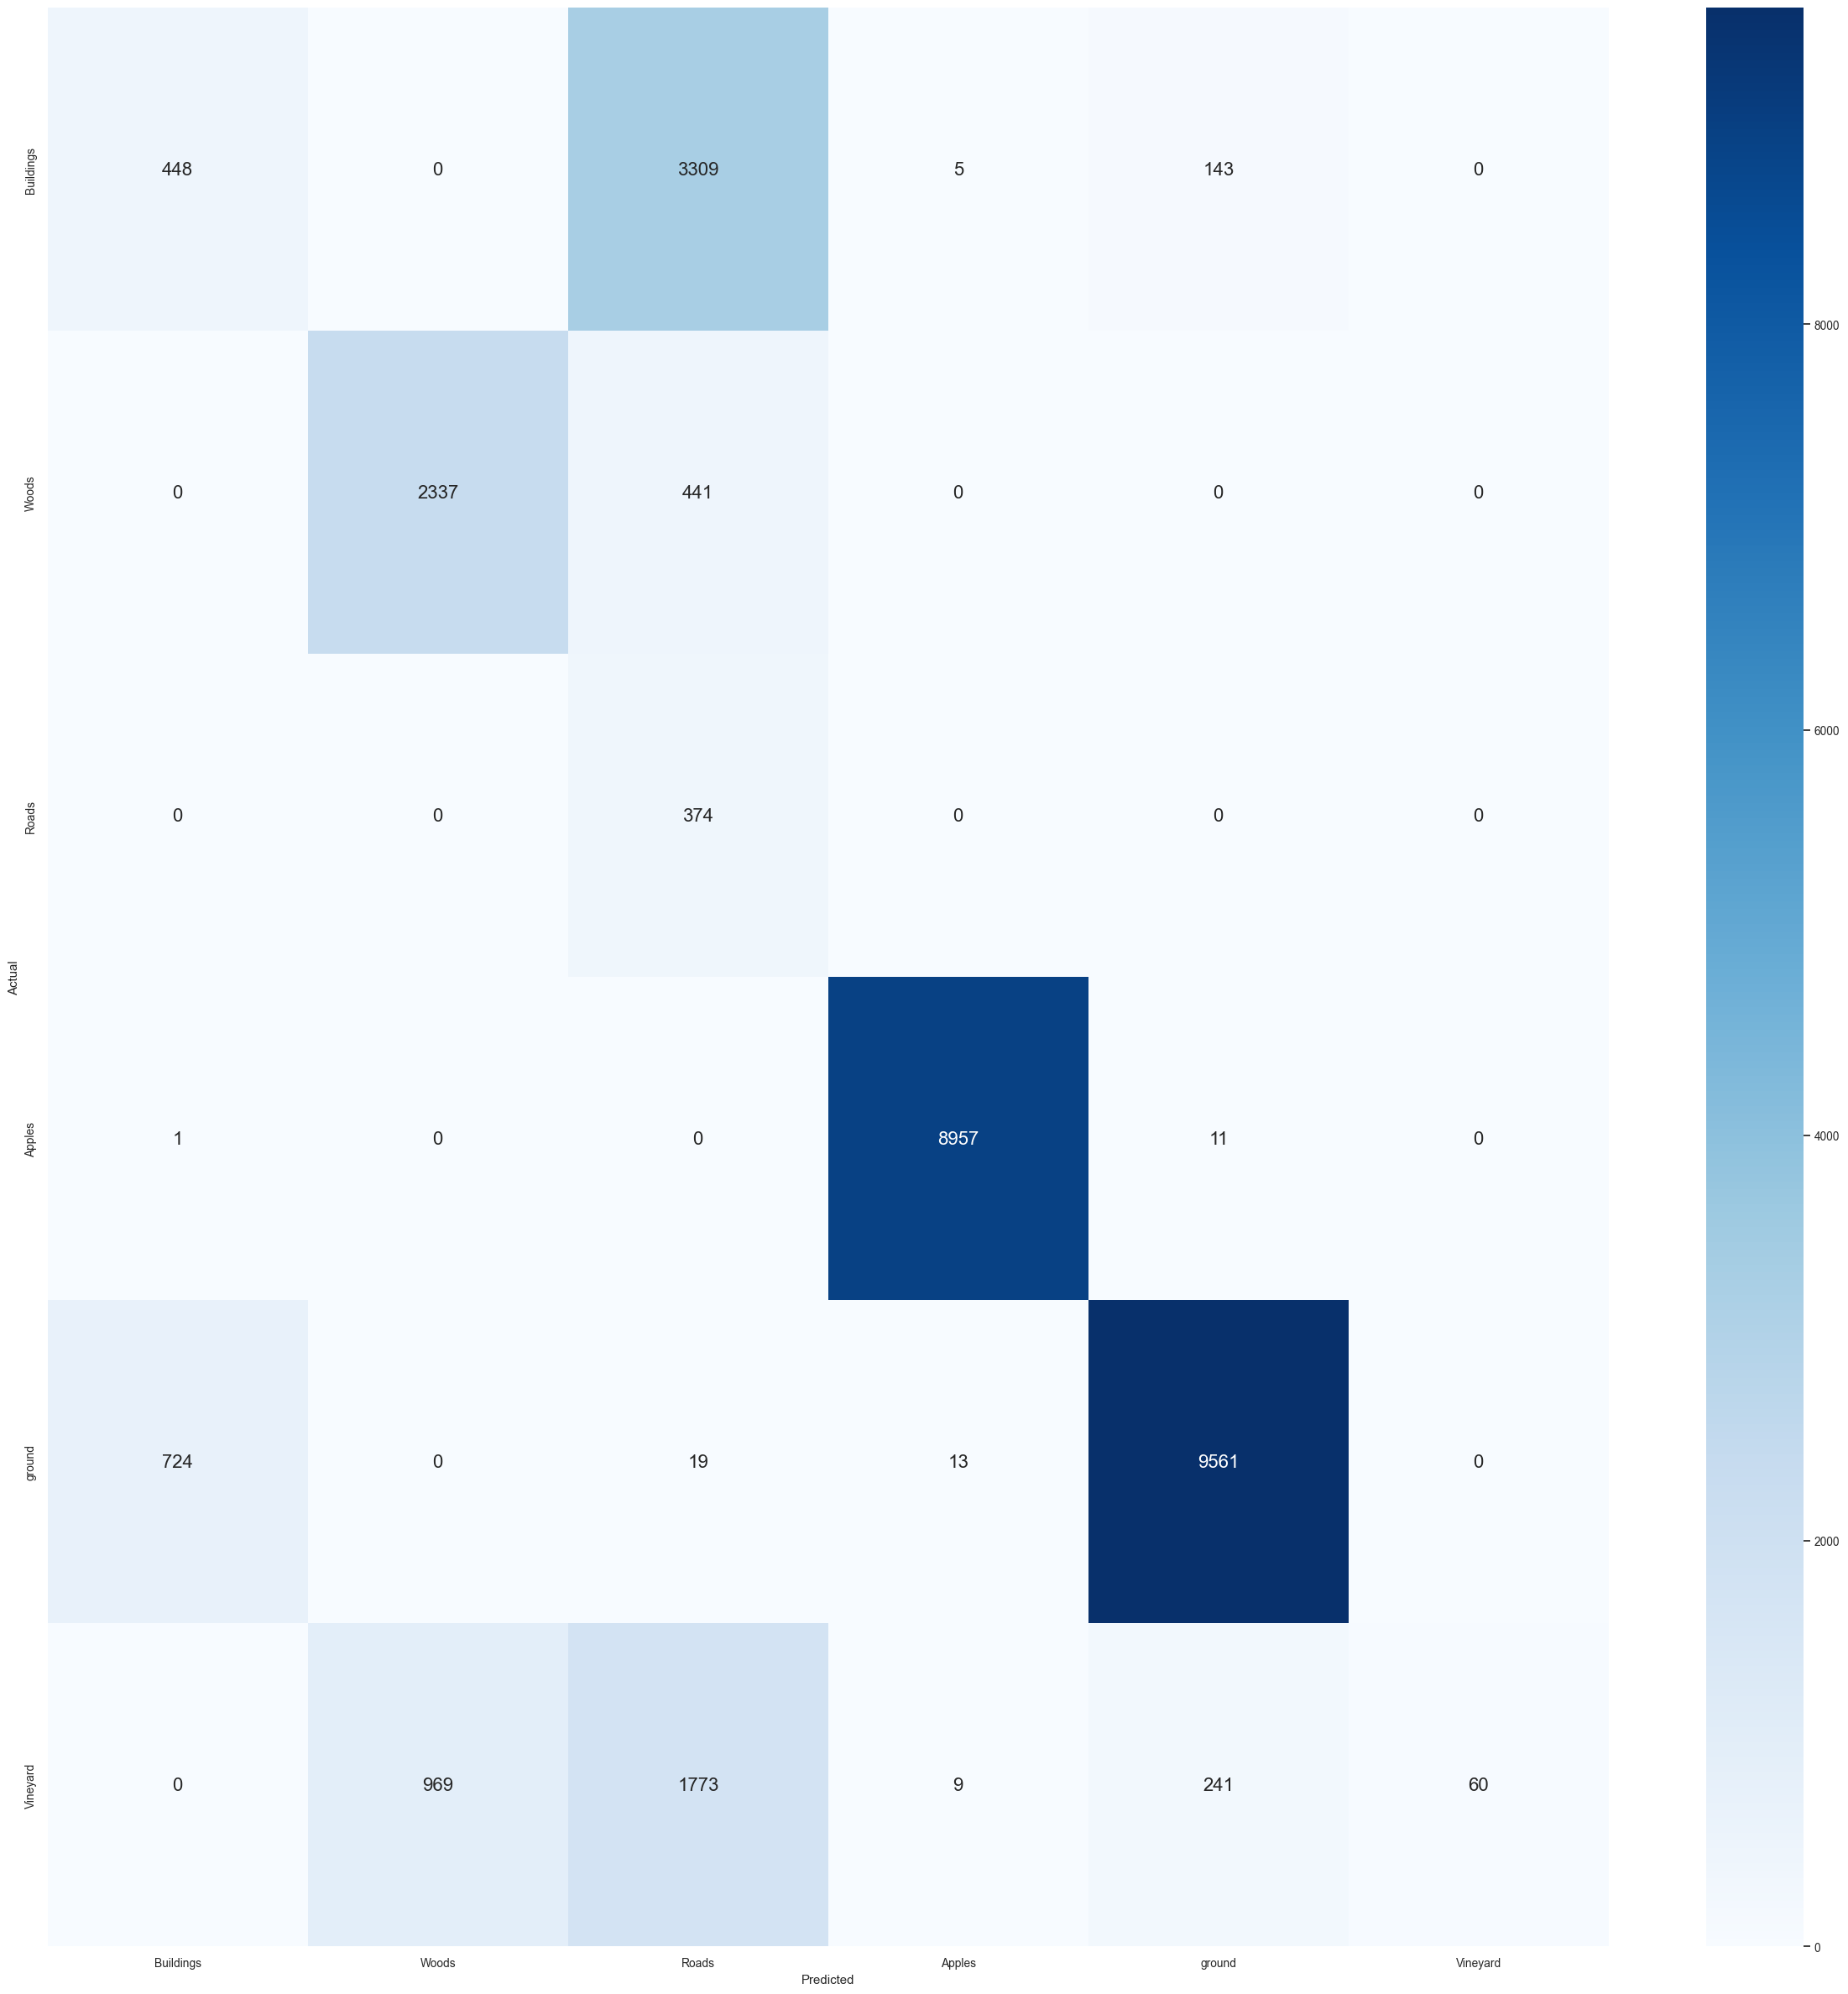

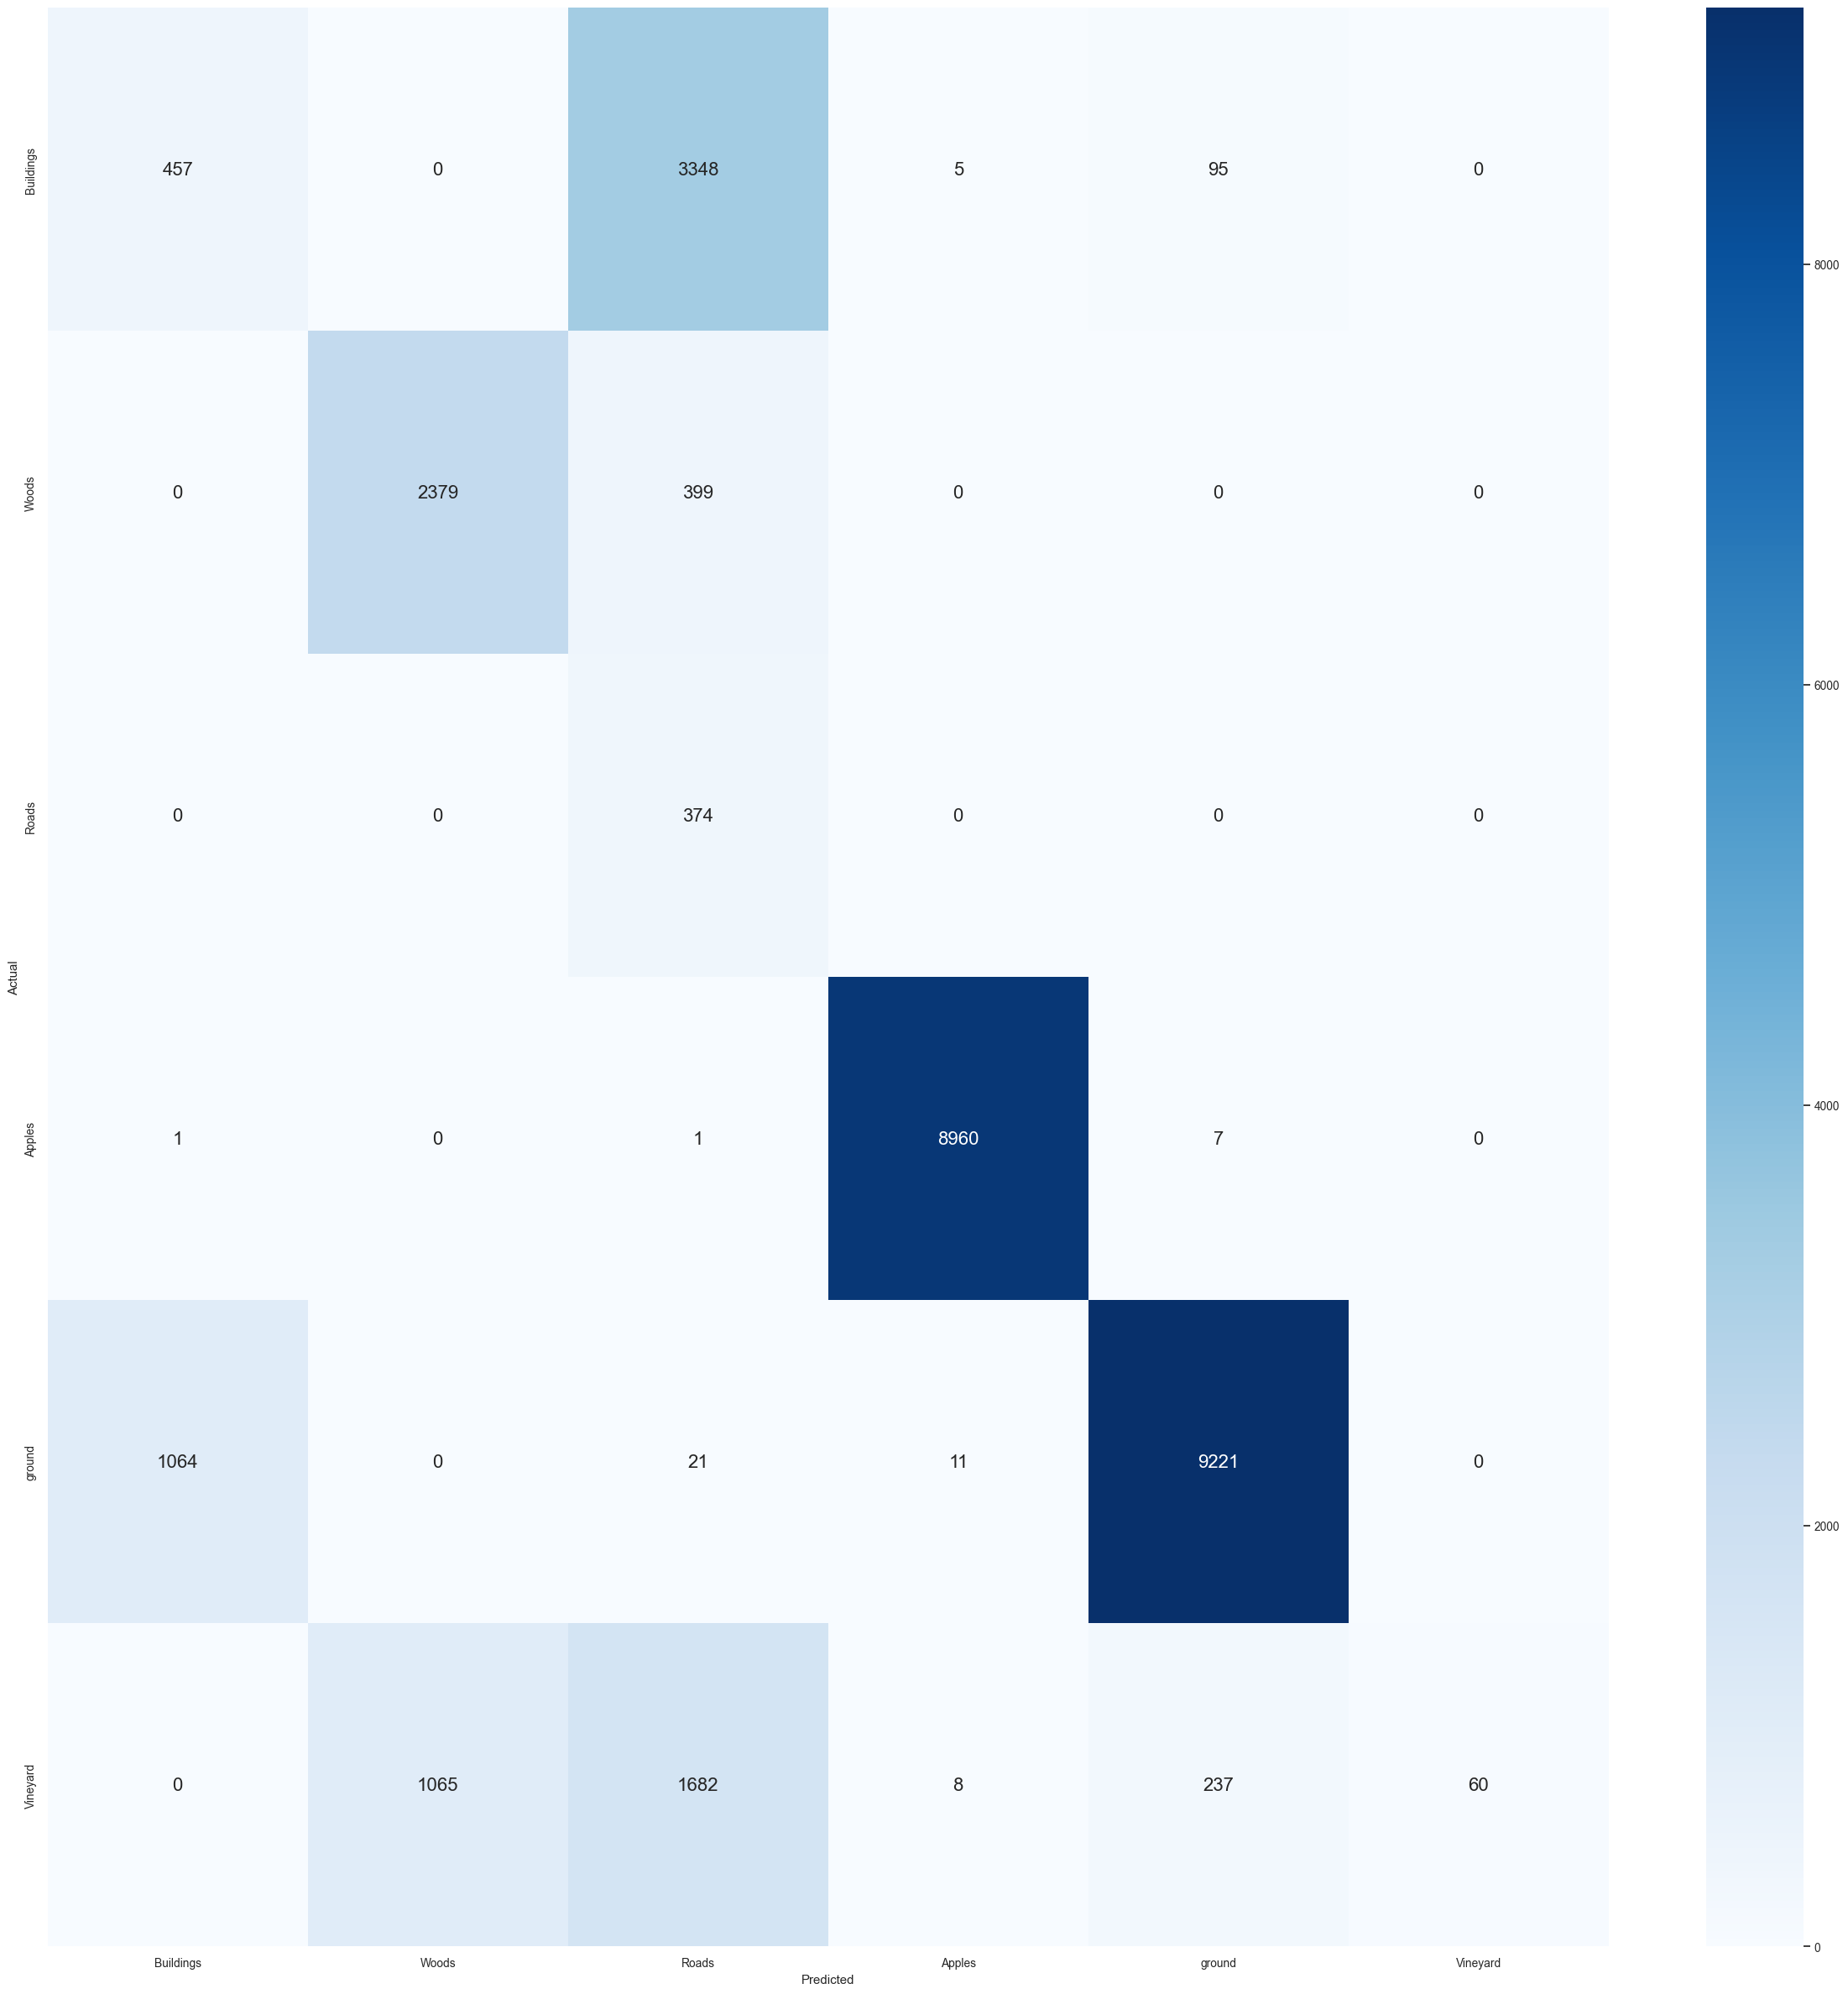

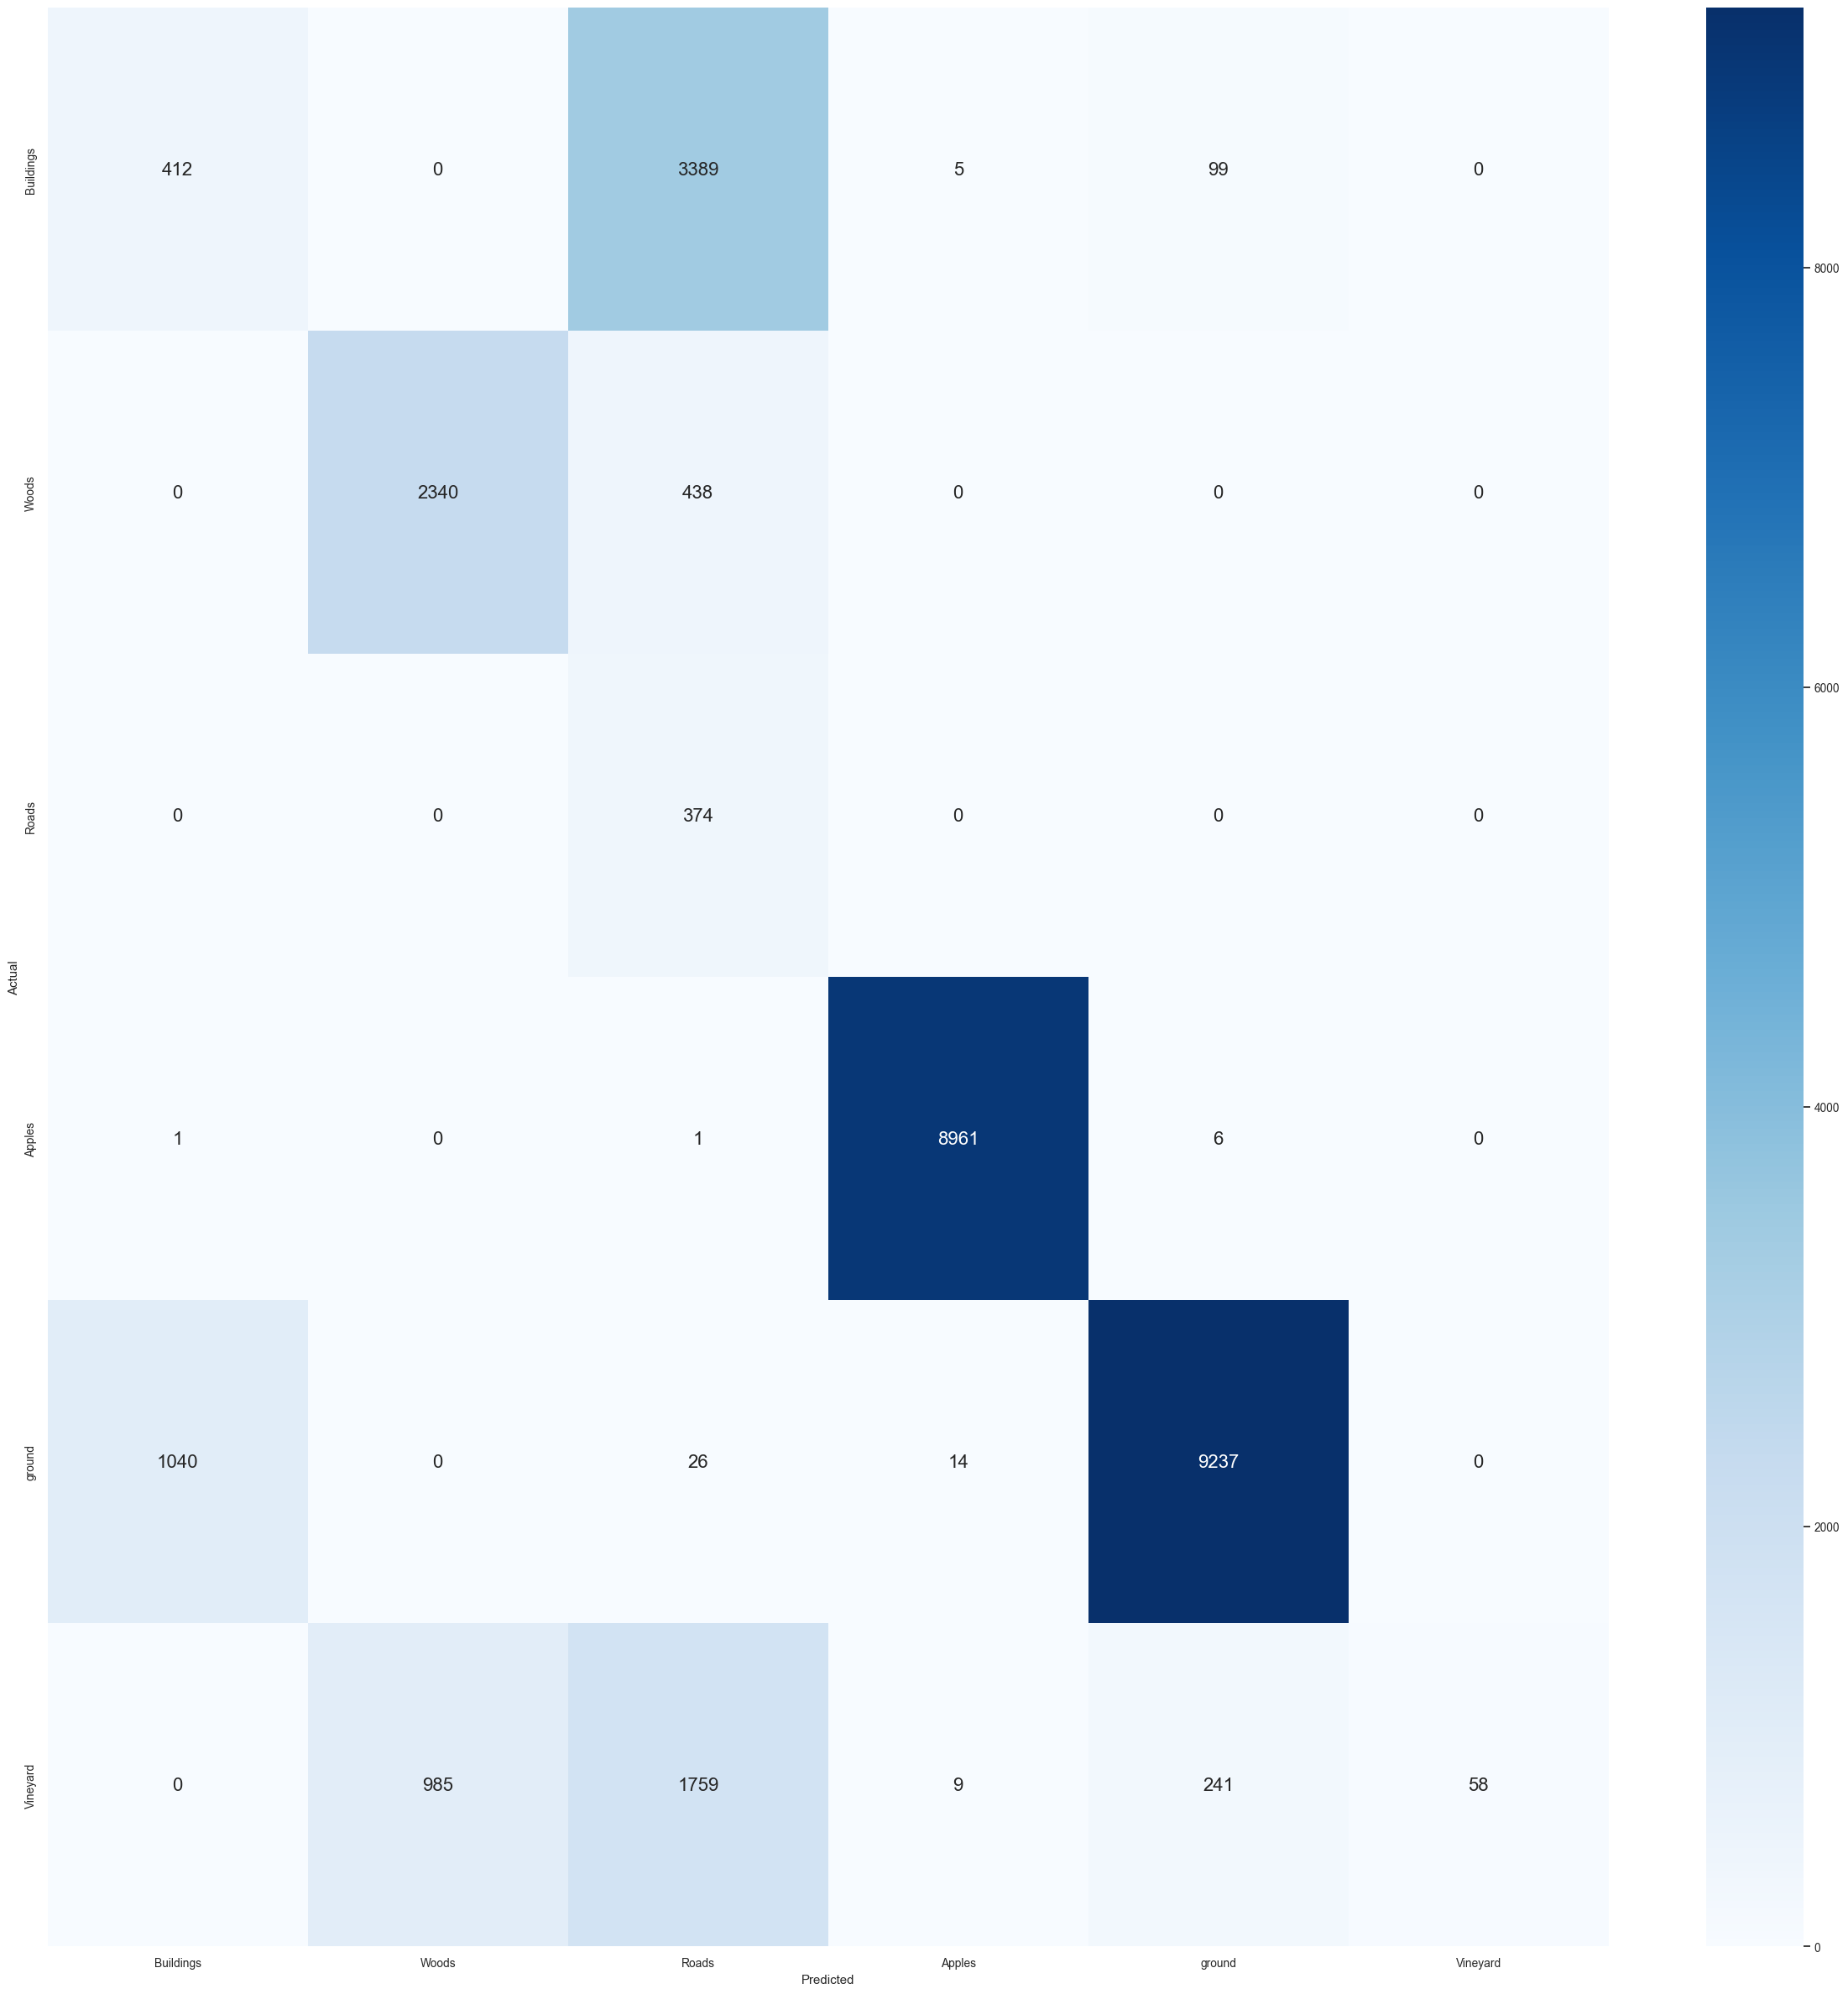

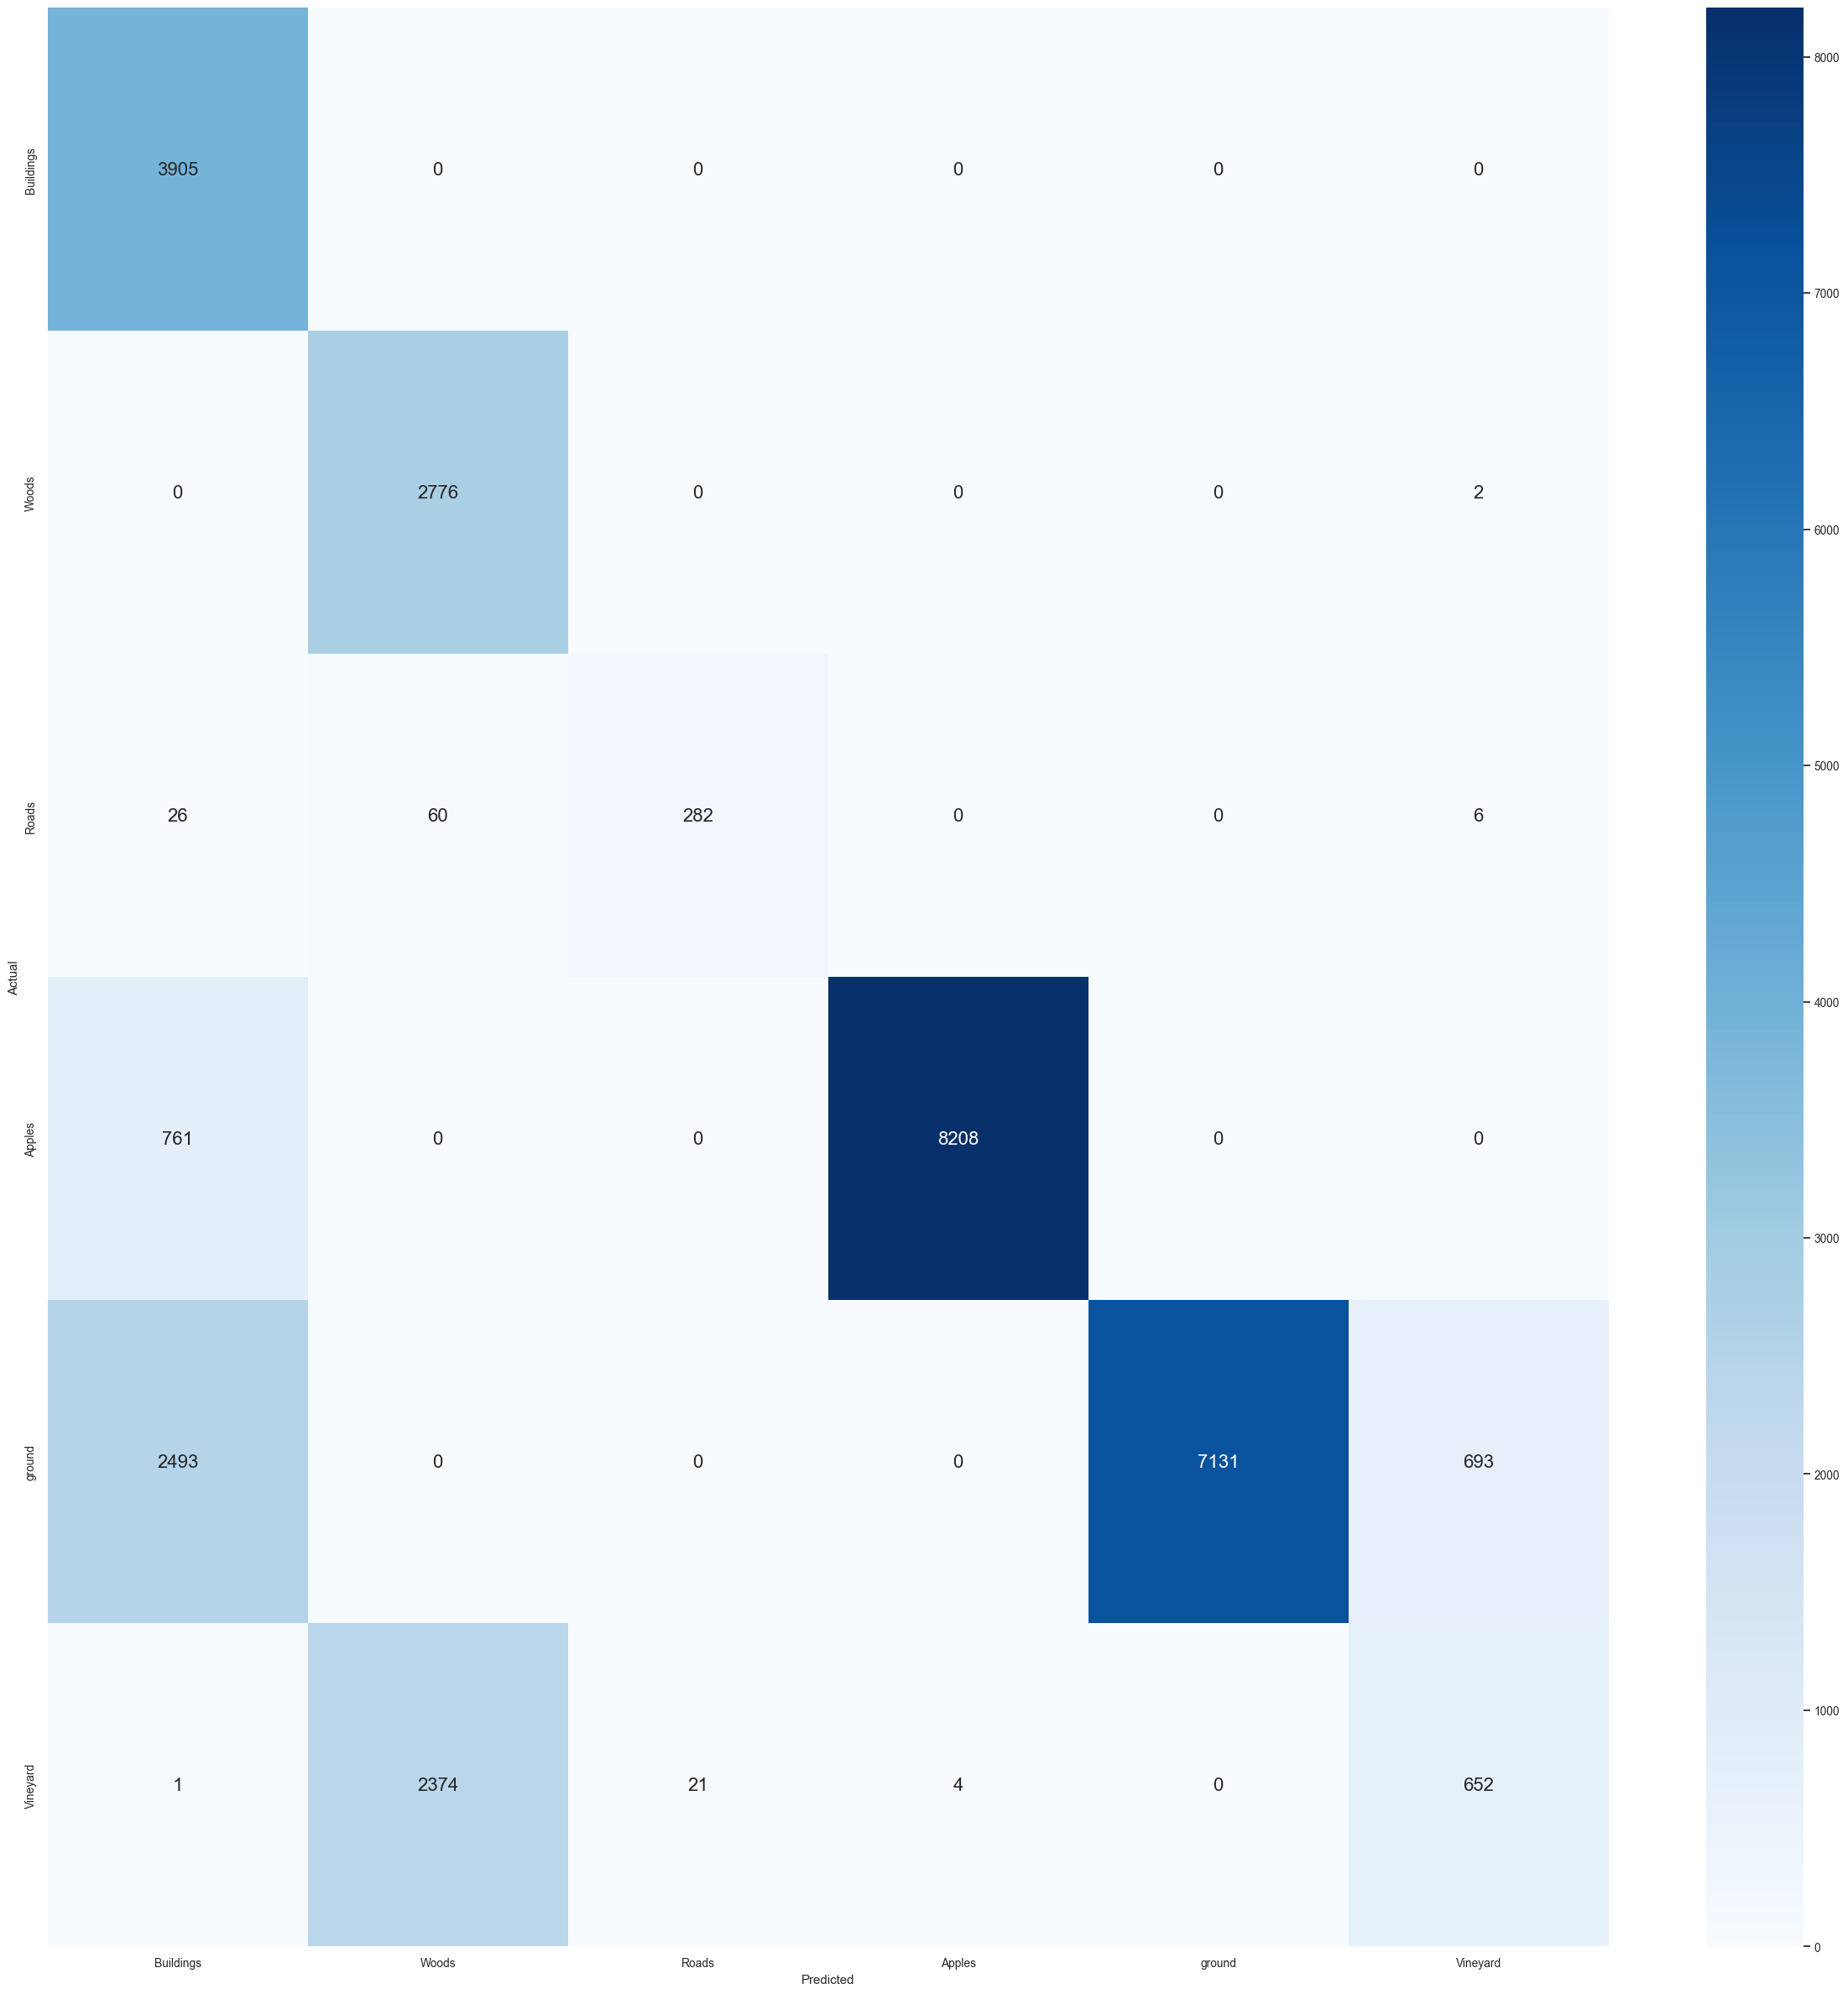

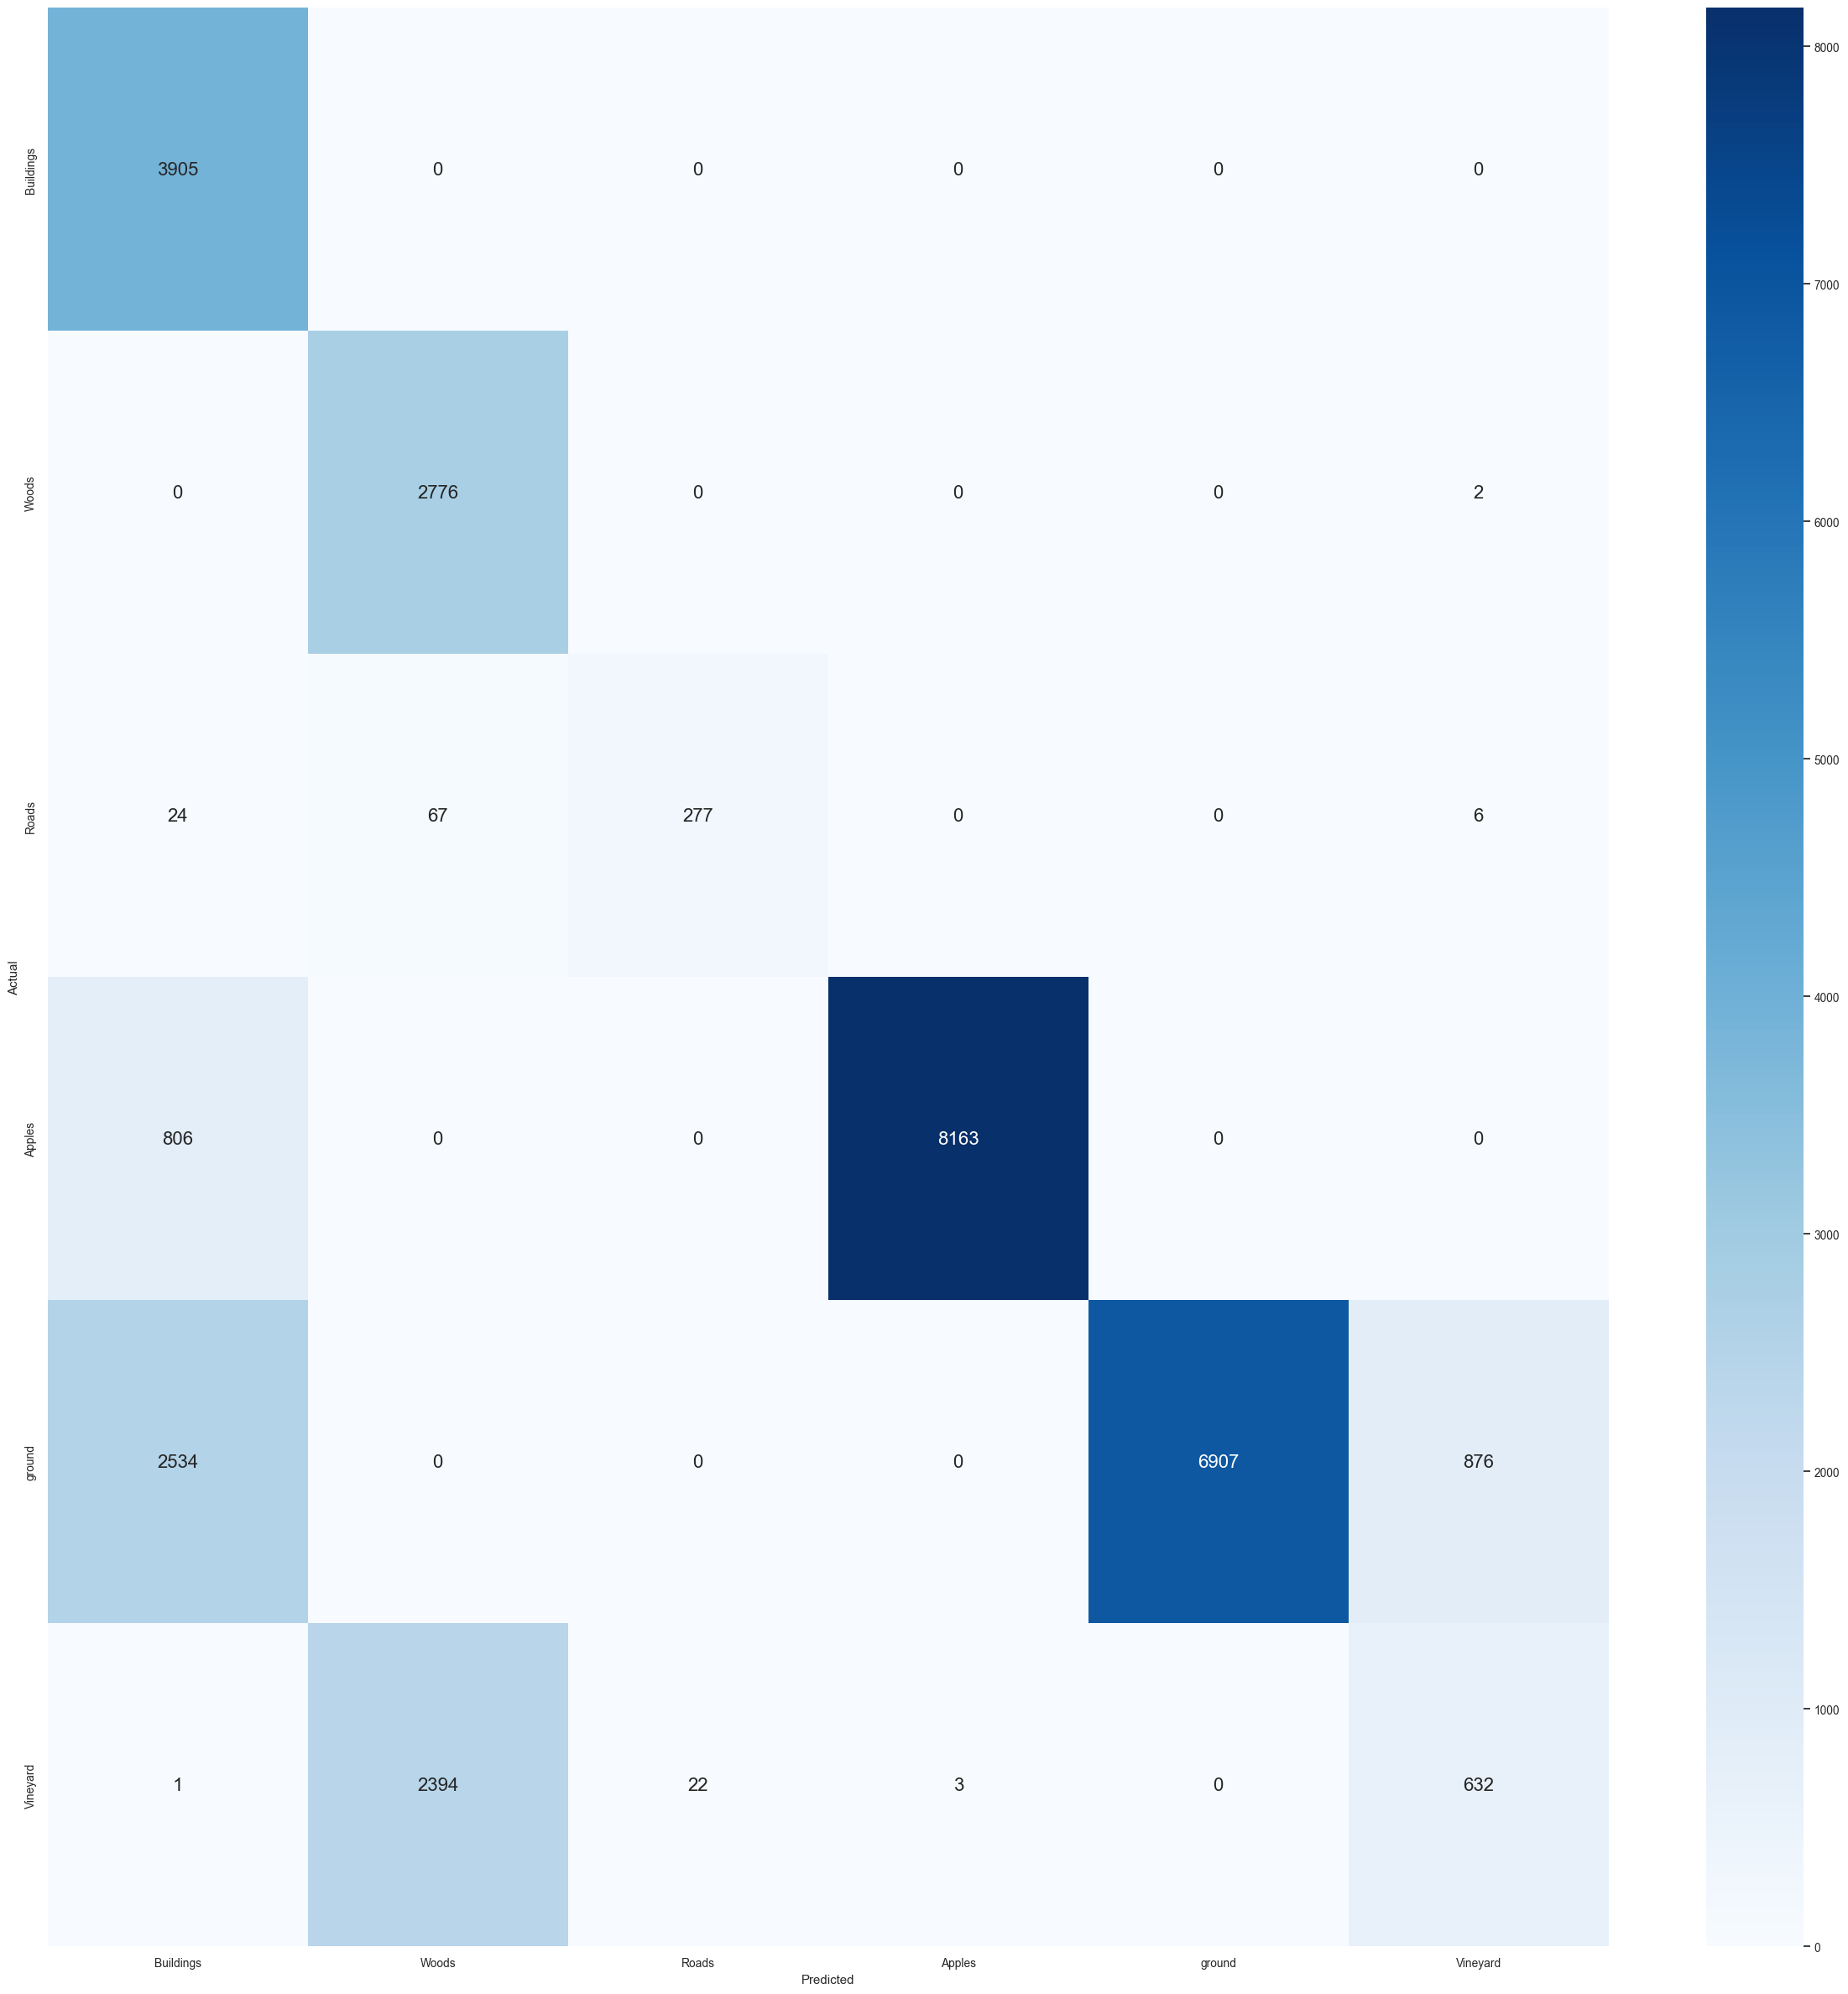

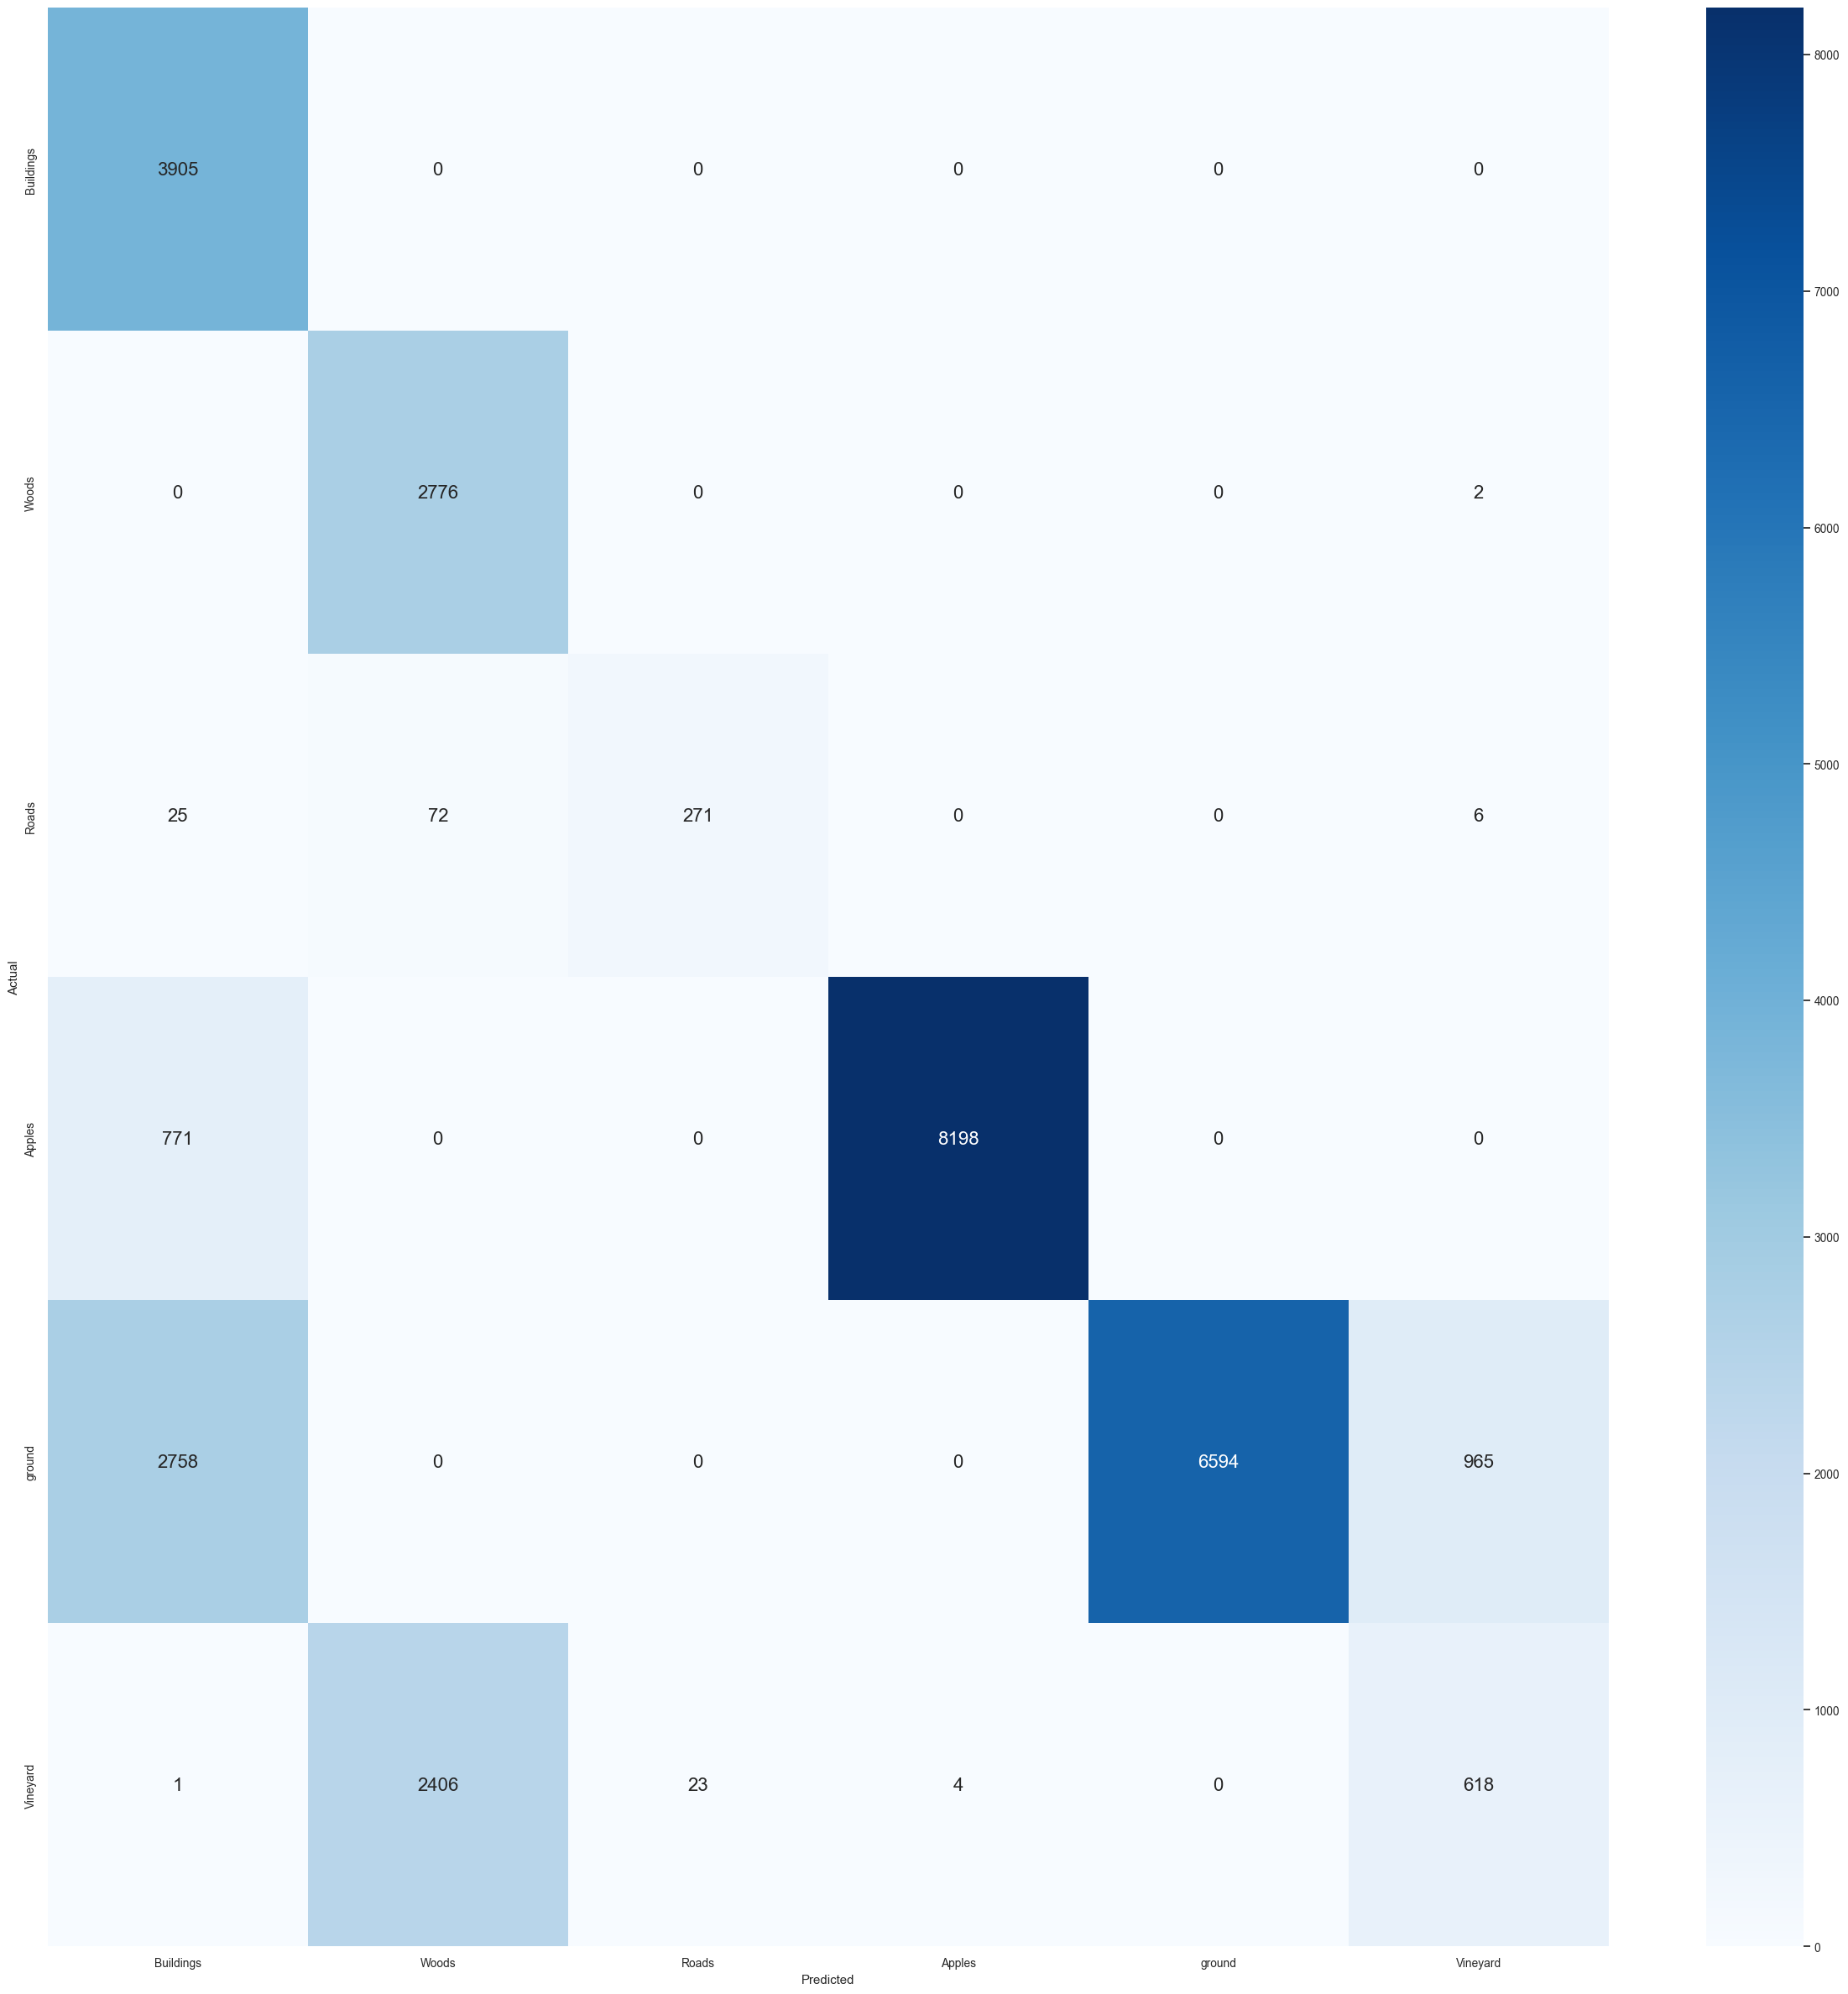

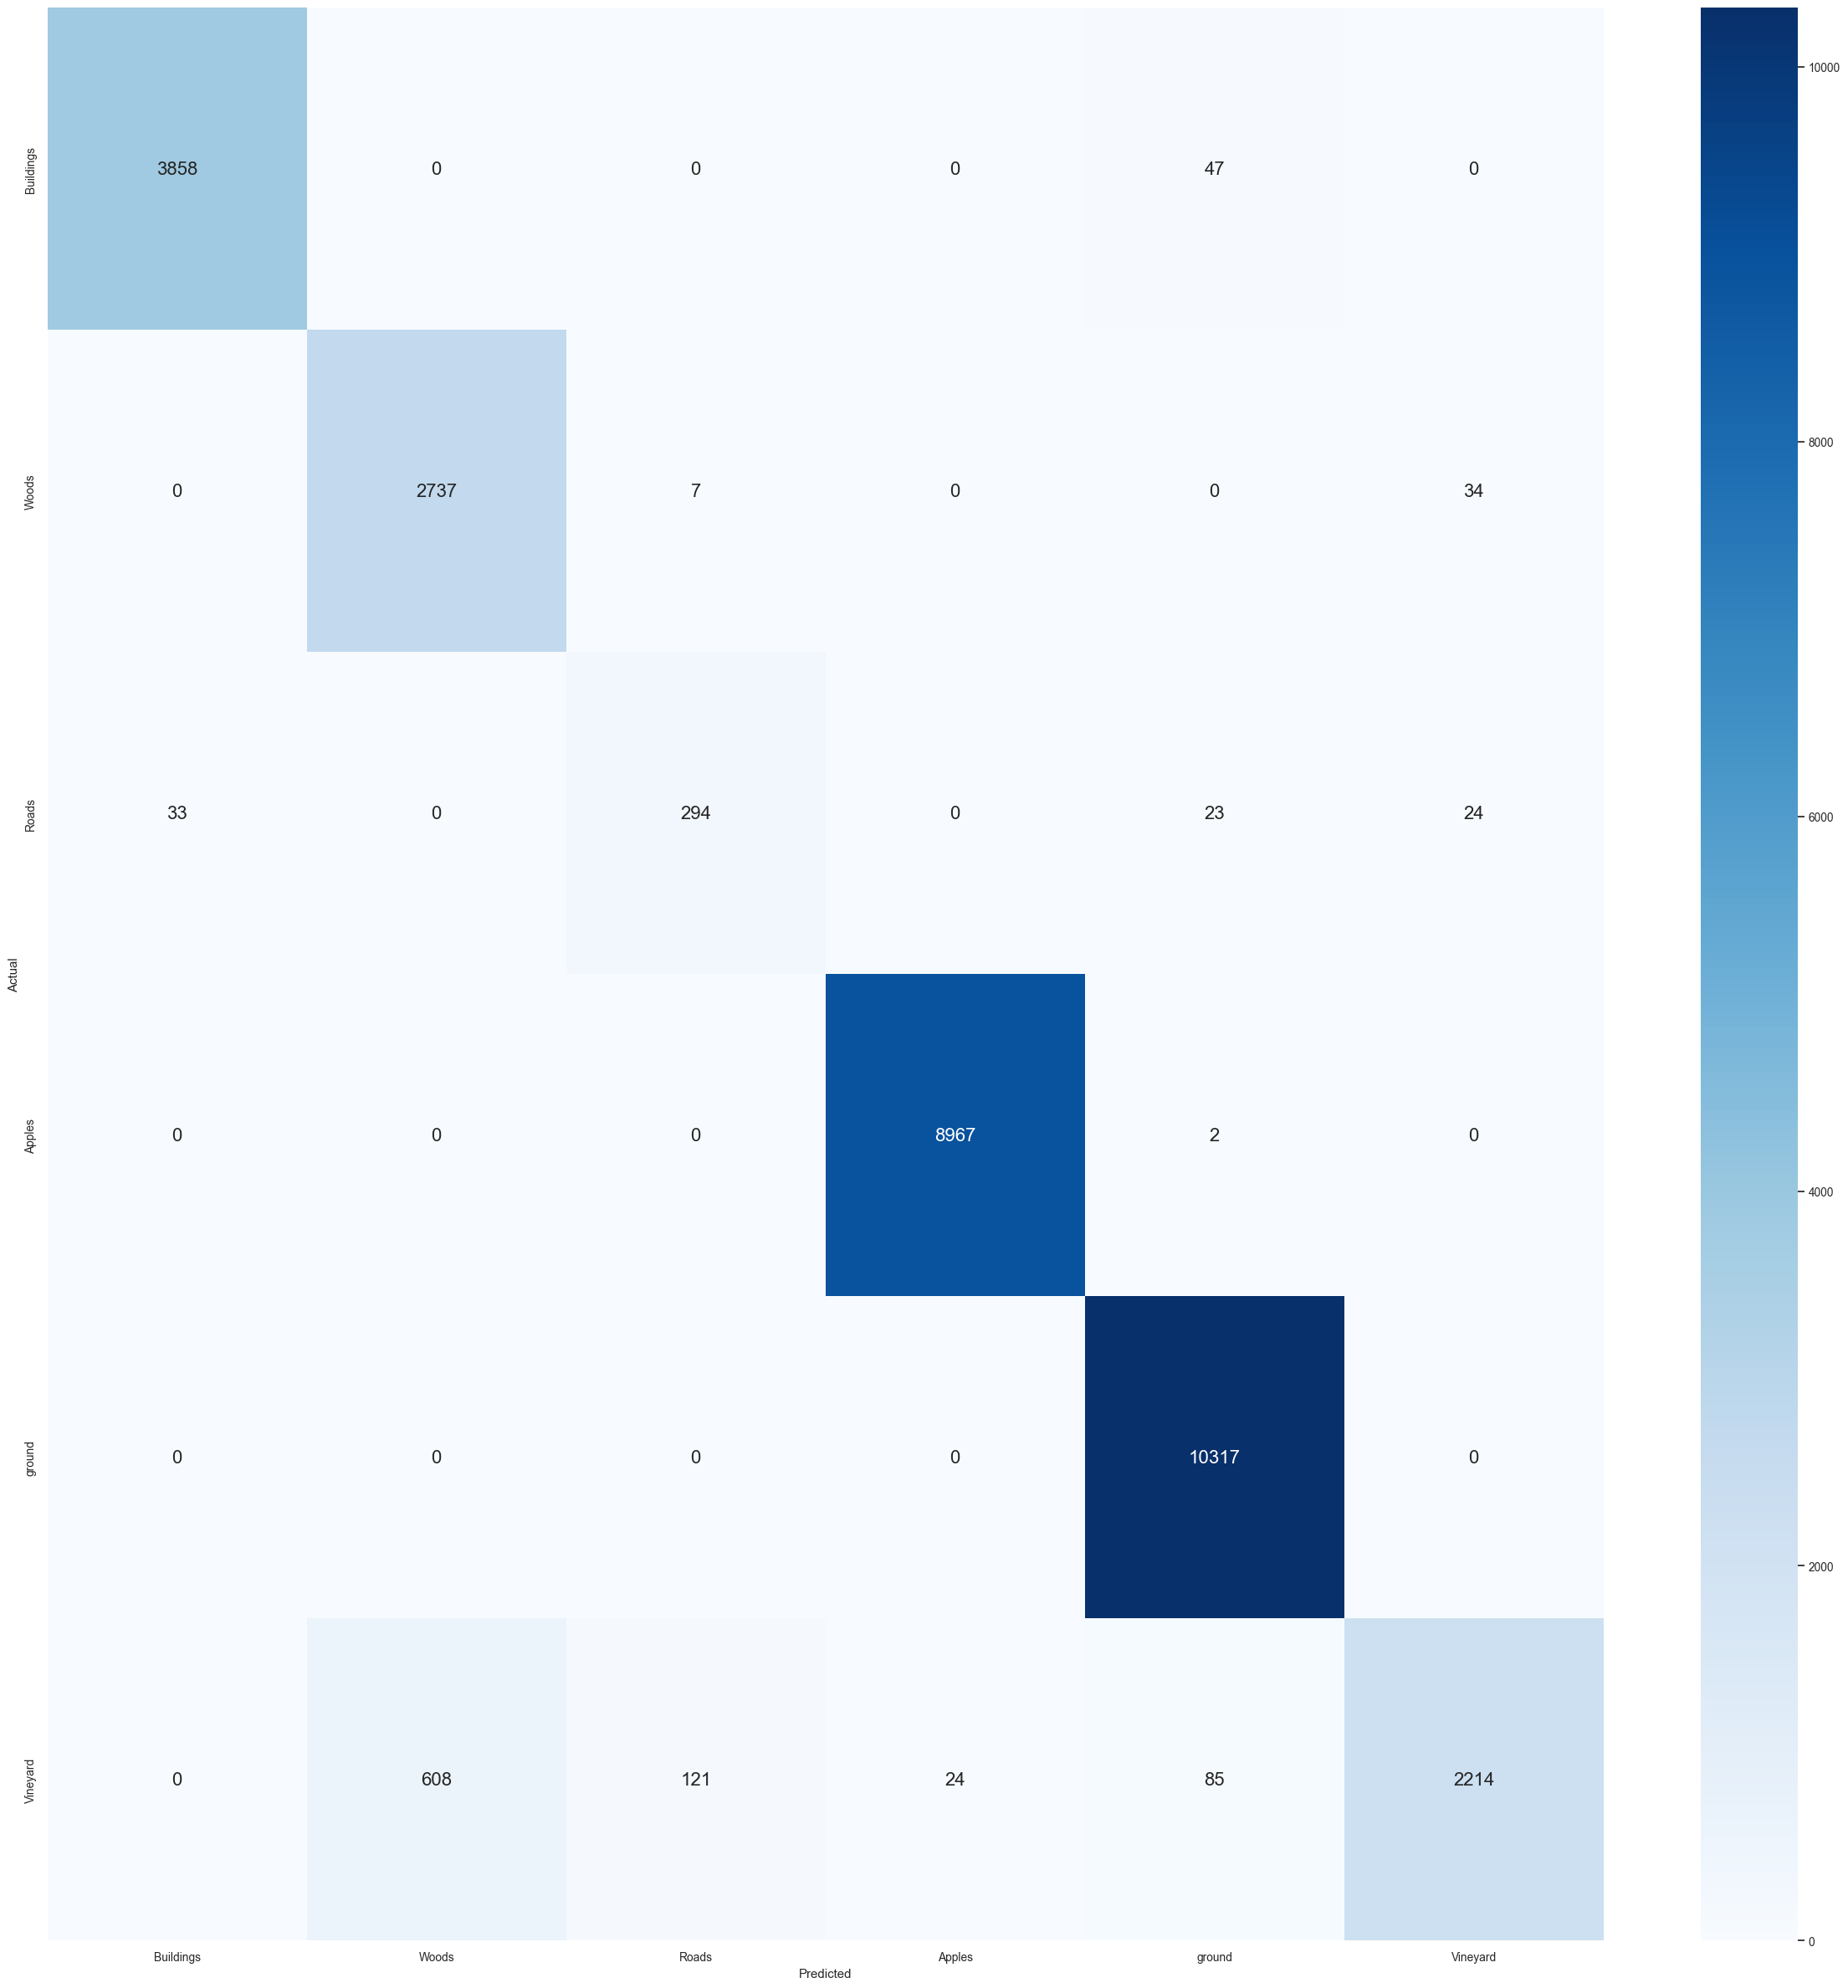

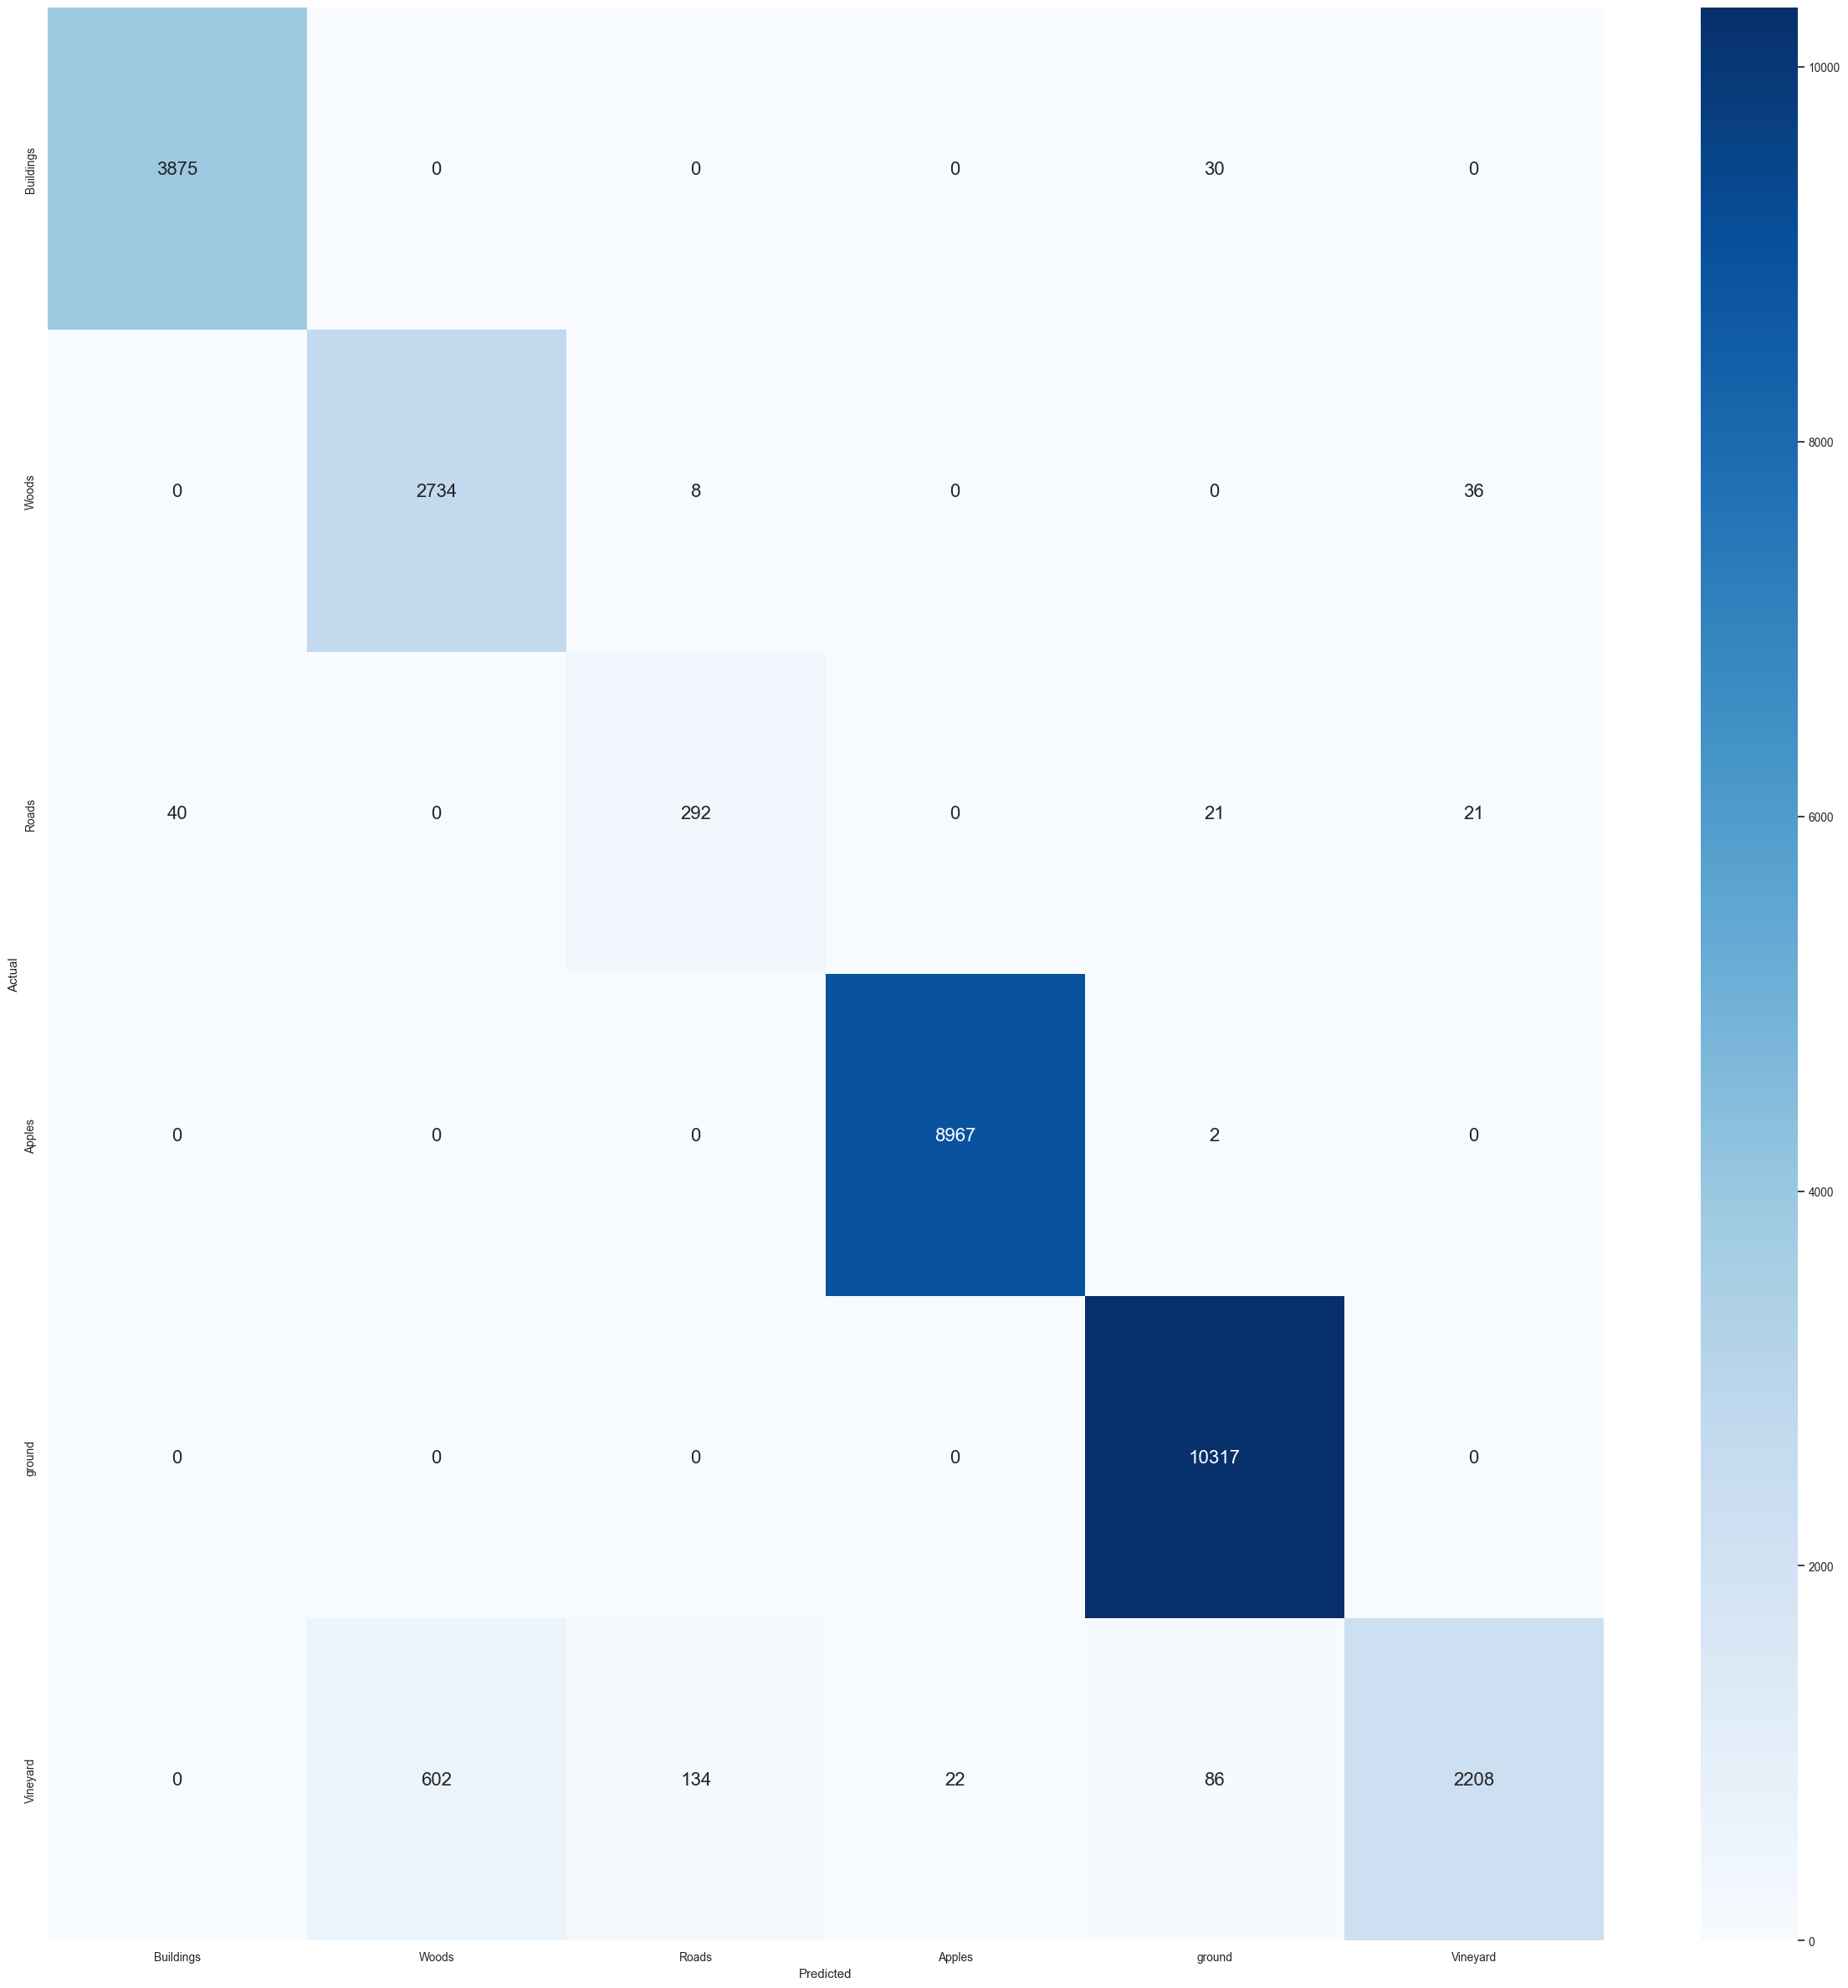

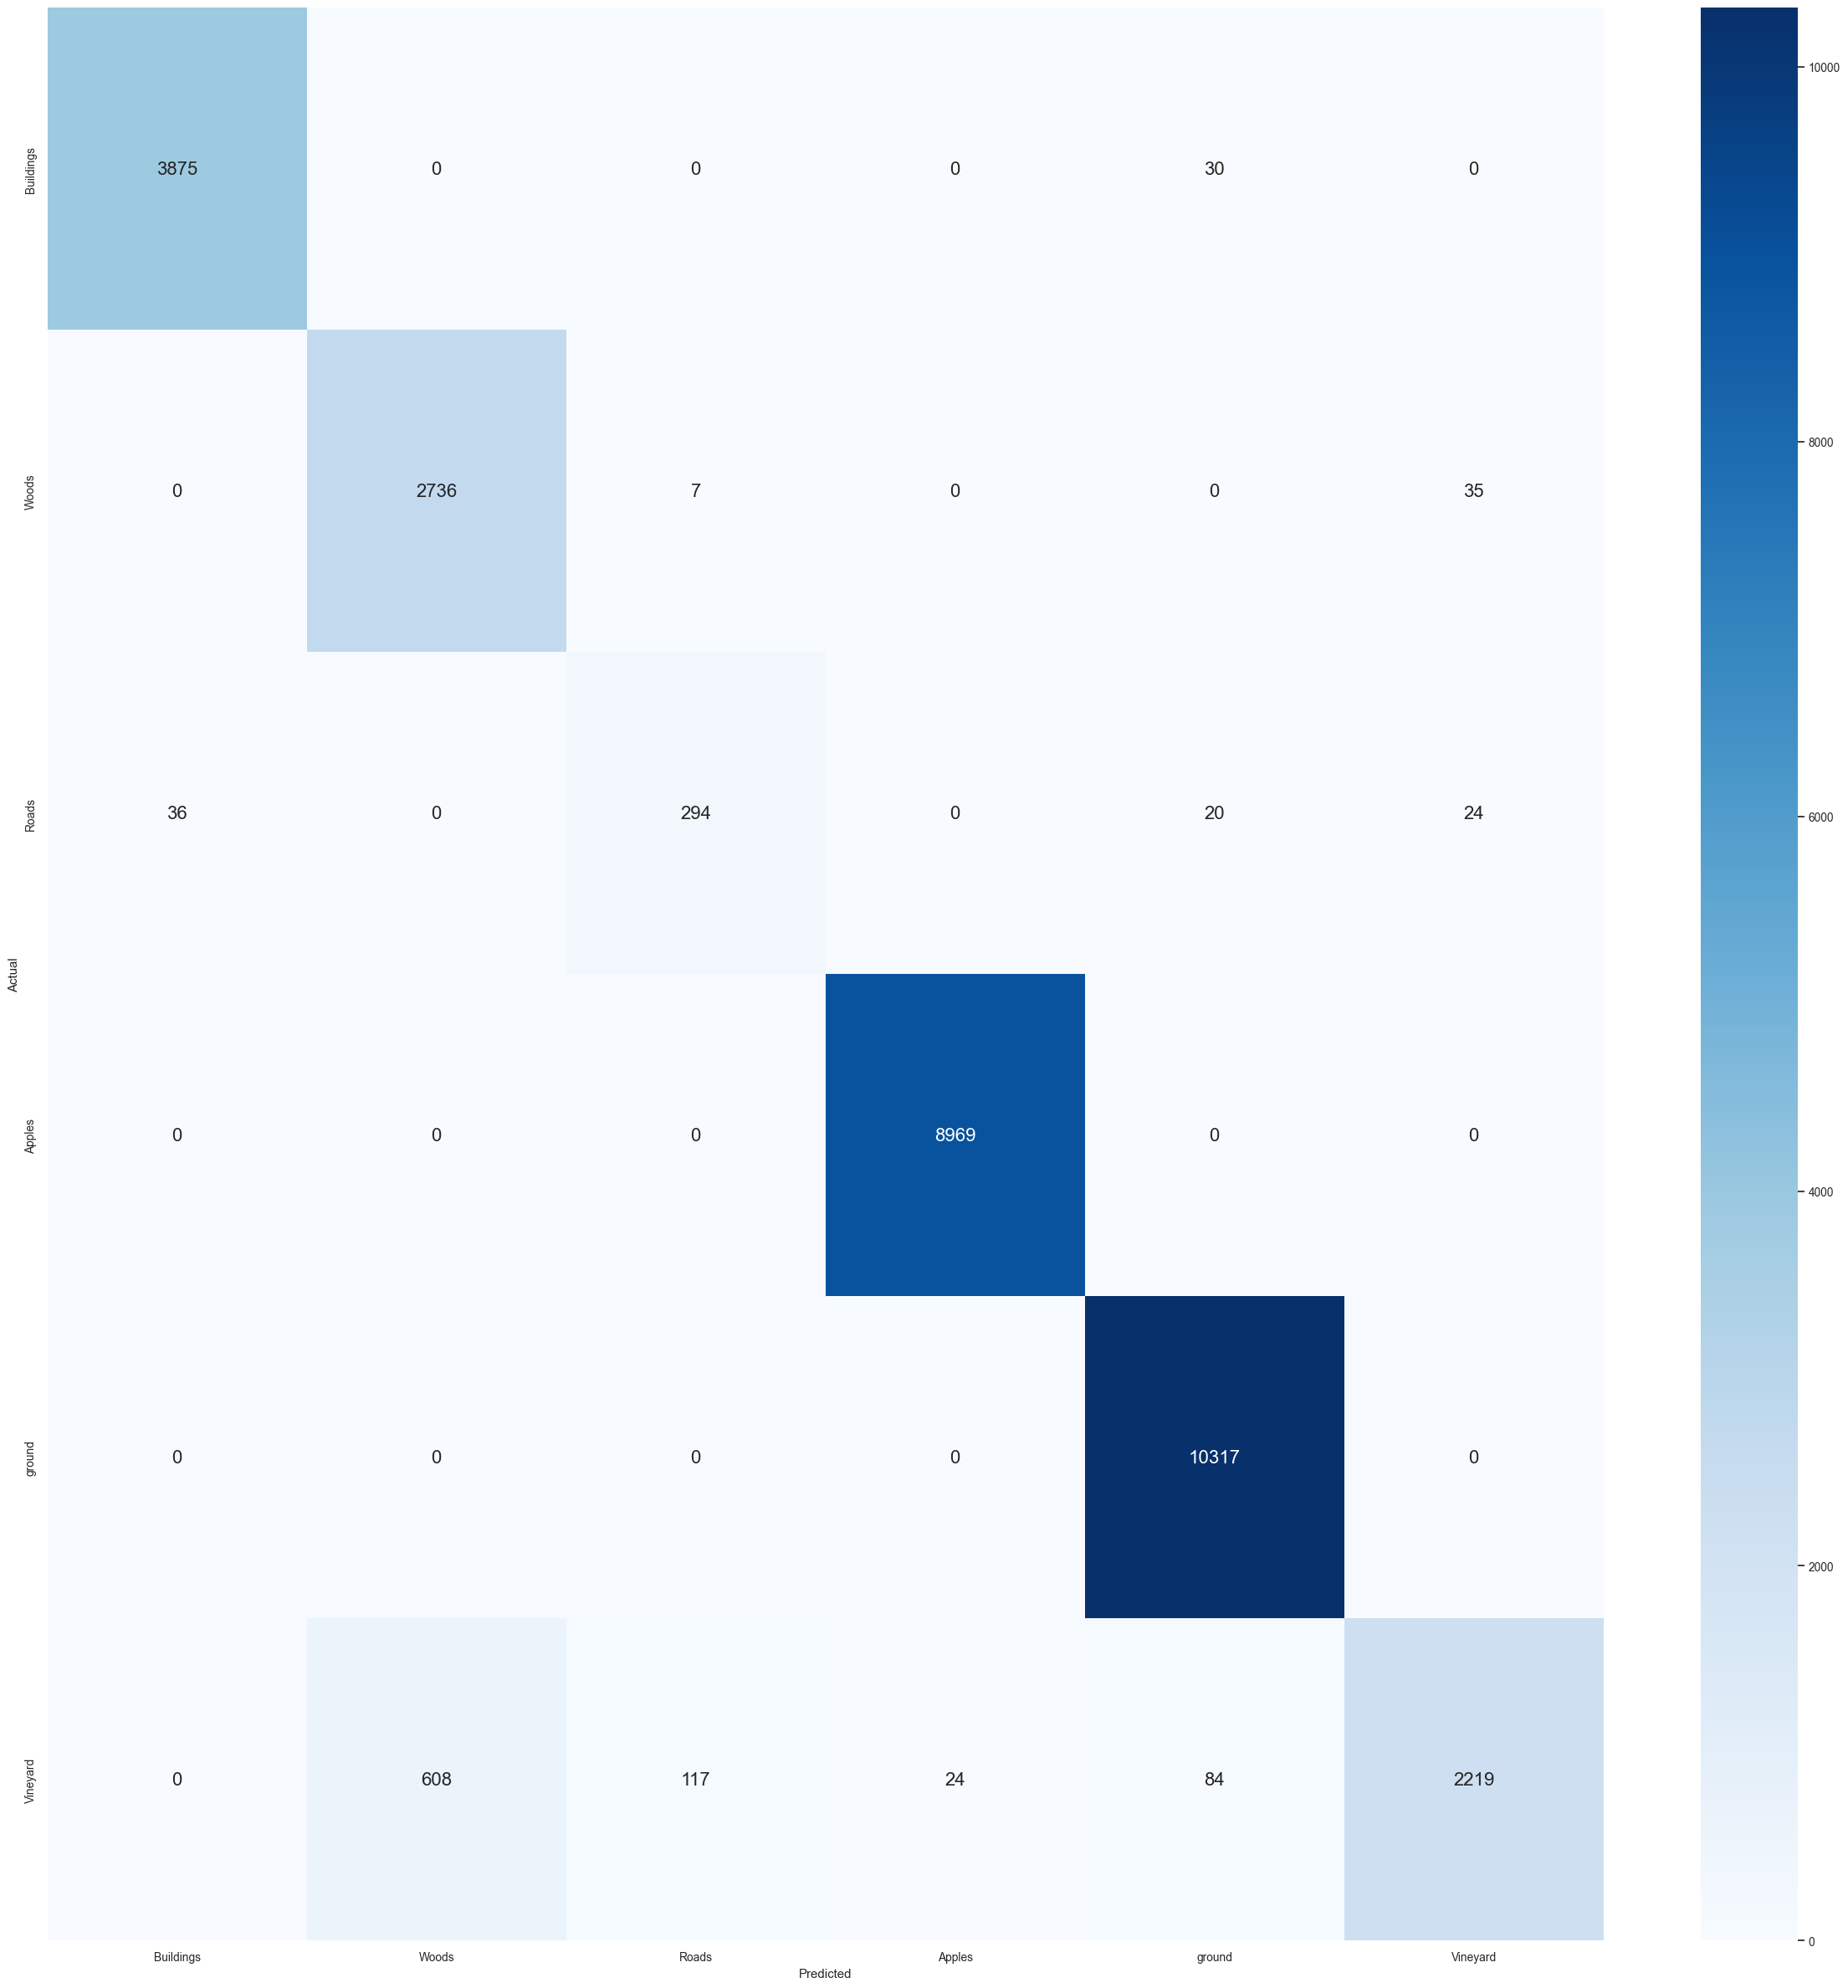

In [9]:
# %%
datasetNames = ["Trento"] # ["Trento", "MUUFL", "Houston"]
MultiModalData = 'LiDAR'
modelName = 'Cross-HL'

patchsize = 11
batch_size = 64 
test_batch_size = 500
EPOCHS = 50
learning_rate = 5e-4 # Lowered from 5e-4 to stop fast overfitting
FM = 16
FileName = 'CrossHL'
num_heads = 8 
mlp_dim = 512
depth = 2 
num_iterations = 1
train_loss = []

def seed_val(seed=14):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

for dataset in datasetNames:
    print(f"---------------------------------- Details for {dataset} dataset---------------------------------------------")
    print('\n')
    try:
        os.makedirs(dataset)
    except FileExistsError:
        pass

    train_dataset_full = HSI_LiDAR_DatasetTrain(dataset=dataset)
    test_dataset = HSI_LiDAR_DatasetTest(dataset=dataset)
    
    NC = train_dataset_full.hs_image.shape[1]
    NCLidar = train_dataset_full.lidar_image.shape[1]
    Classes = len(torch.unique(train_dataset_full.lbls))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # ---- CLIP text embeddings (semantic prior) ----
    clip_model, _, _ = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")
    tokenizer = open_clip.get_tokenizer("ViT-B-32")
    clip_model = clip_model.to(device).eval()  

    class_names = ["Buildings", "Woods", "Roads", "Apples", "ground", "Vineyard"]
    assert len(class_names) == Classes, "class_names count must match Classes!"

    # ---- attribute prompts sets ----
    prompt_sets = {
        "name": {
            "Buildings": ["Buildings"],
            "Woods": ["Woods"],
            "Roads": ["Roads"],
            "Apples": ["Apples"],
            "ground": ["ground"],
            "Vineyard": ["Vineyard"]
        },
        "spectral": {
            "Buildings": [
                "hyperspectral signature of man-made materials with relatively flat reflectance in visible bands",
                "urban surfaces with weaker vegetation red-edge and moderate near-infrared reflectance",
                "built materials with smoother spectrum and limited chlorophyll absorption features",
            ],
            "Woods": [
                "vegetation with strong near-infrared reflectance and a pronounced red-edge transition",
                "plant canopy with chlorophyll absorption in red and high near-infrared plateau",
                "green vegetation with low red reflectance and high near-infrared response",
            ],
            "Roads": [
                "impervious surface with low near-infrared reflectance compared to vegetation",
                "asphalt or concrete with smooth spectral curve and weak red-edge features",
                "linear urban surface with moderate visible reflectance and low near-infrared response",
            ],
            "Apples": [
                "crop vegetation with chlorophyll absorption and strong near-infrared reflectance",
                "vegetation canopy with red-edge transition and high near-infrared plateau",
            ],
            "ground": [
                "bare soil with monotonic increase from visible to near-infrared reflectance",
                "non-vegetated ground with smoother spectrum and weak red-edge features",
                "soil surface with moderate near-infrared reflectance and reduced chlorophyll absorption",
            ],
            "Vineyard": [
                "row crop vegetation with red-edge transition and strong near-infrared reflectance",
                "structured vegetation canopy with chlorophyll absorption in red and high near-infrared plateau",
            ],
        }
    }

    test_patch_hsi = test_dataset.hs_image
    test_patch_lidar = test_dataset.lidar_image
    test_label = test_dataset.lbls

    fewshot_pcts = [0.01, 0.05, 0.10]   # 1%, 5%, 10%

    experiments = [
        ("baseline", 0.0, None),            # no semantic loss
        ("name",     0.03, "name"),         # name prompts # Bumped up from 0.03
        ("spectral", 0.03, "spectral"),     # attribute prompts # Bumped up from 0.03
    ]

    for pct in fewshot_pcts:
        # Create the subset once per percentage
        train_dataset = make_fewshot_subset(train_dataset_full, pct=pct, seed=14)
        train_loader = dataf.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

        print(f"\n=====================================================================")
        print(f"### Few-shot setting: {int(pct*100)}% labels | Train samples: {len(train_dataset)} ###")
        print(f"=====================================================================\n")

        for exp_name, lambda_sem, prompt_mode in experiments:
            run_tag = f"{exp_name}_pct{int(pct*100)}_lam{lambda_sem}"
            print(f"\n---> Starting Experiment: {exp_name.upper()} | Tag: {run_tag}")

            # Generate Embeddings for current experiment
            text_embeds = None
            if prompt_mode is not None:
                with torch.no_grad():
                    class_protos = []
                    for cname in class_names:
                        prompts = prompt_sets[prompt_mode][cname]
                        text_tokens = tokenizer(prompts).to(device)
                        te = clip_model.encode_text(text_tokens)          
                        te = F.normalize(te, dim=-1)
                        proto = F.normalize(te.mean(dim=0), dim=-1)       
                        class_protos.append(proto)
                    text_embeds = torch.stack(class_protos, dim=0)        

            seed_val(14)
            for iterNum in range(num_iterations):
                print(f"Iter {iterNum+1}/{num_iterations} | HS bands: {NC}, LiDAR channels: {NCLidar}, Classes: {Classes}")
                
                KAPPA, OA, AA = [], [], []
                ELEMENT_ACC = np.zeros((1, Classes))

                model = CrossHL_Transformer(FM=FM, NC=NC, NCLidar=NCLidar, Classes=Classes, patchsize=patchsize).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-3)
                loss_func = nn.CrossEntropyLoss()
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)

                BestAcc = 0
                start = time.time()

                for epoch in range(EPOCHS):
                    model.train()
                    for step, (batch_hsi, batch_ldr, batch_lbl) in enumerate(train_loader):
                        batch_hsi = batch_hsi.to(device)
                        batch_ldr = batch_ldr.to(device)
                        batch_lbl = batch_lbl.to(device)

                        logits, img_embed = model(batch_hsi, batch_ldr, return_embed=True)
                        loss_ce = loss_func(logits, batch_lbl)

                        # Semantic Loss Calculation
                        loss_sem = torch.tensor(0.0).to(device)
                        if text_embeds is not None and lambda_sem > 0:
                            target_text = text_embeds[batch_lbl]  
                            cos_sim = (img_embed * target_text).sum(dim=-1)
                            loss_sem = (1.0 - cos_sim).mean()

                        loss = loss_ce + (lambda_sem * loss_sem)

                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    scheduler.step()

                    # ONLY EVALUATE EVERY 10 EPOCHS OR ON THE LAST EPOCH TO SAVE TIME
                    if (epoch + 1) % 10 == 0 or epoch == EPOCHS - 1:
                        model.eval()
                        with torch.no_grad():
                            y_pred = np.empty((len(test_label)), dtype='float32')
                            number = len(test_label) // test_batch_size
                            for i in range(number):
                                temp = test_patch_hsi[i * test_batch_size:(i + 1) * test_batch_size].to(device)
                                temp1 = test_patch_lidar[i * test_batch_size:(i + 1) * test_batch_size].to(device)
                                temp2 = model(temp, temp1)
                                temp3 = torch.max(temp2, 1)[1].squeeze()
                                y_pred[i * test_batch_size:(i + 1) * test_batch_size] = temp3.cpu()
                            if (i + 1) * test_batch_size < len(test_label):
                                temp = test_patch_hsi[(i + 1) * test_batch_size:].to(device)
                                temp1 = test_patch_lidar[(i + 1) * test_batch_size:].to(device)
                                temp2 = model(temp, temp1)
                                temp3 = torch.max(temp2, 1)[1].squeeze()
                                y_pred[(i + 1) * test_batch_size:] = temp3.cpu()

                            y_pred = torch.from_numpy(y_pred).long()
                            accuracy = (y_pred == test_label).float().mean()

                        print(f"Epoch {epoch} | CE loss={loss_ce.item():.4f} | Sem loss={loss_sem.item():.4f} | test acc={accuracy.item()*100:.2f}")

                        if accuracy > BestAcc:
                            BestAcc = accuracy
                            torch.save(model.state_dict(), f"{dataset}/net_params_{FileName}_{run_tag}.pkl")

                # Move these OUTSIDE the epoch loop so it only prints train time once it's done training
                end = time.time()
                print('Train time (s):', end - start)

                # load best and final report
                state_dict = torch.load(f"{dataset}/net_params_{FileName}_{run_tag}.pkl", map_location='cpu')
                model.load_state_dict(state_dict)
                model.to(device)
                model.eval()

                # Passing run_tag instead of dataset for distinct matrix naming
                confusion_mat, overall_acc, class_acc, avg_acc, kappa_score = utils.result_reports(
                    test_patch_hsi, test_patch_lidar, test_label, run_tag, model, iterNum, device
                )

                KAPPA.append(kappa_score)
                OA.append(overall_acc)
                AA.append(avg_acc)
                ELEMENT_ACC[0, :] = class_acc

                torch.save(model, f"{dataset}/best_model_{FileName}_{run_tag}_Iter{iterNum}.pt")
                print(f"Overall Accuracy ({run_tag}) = {overall_acc:.2f}")

            # Log results for this specific ablation
            logger.log_result(OA, AA, KAPPA, ELEMENT_ACC, f'./{dataset}/{FileName}_Report_{dataset}_{run_tag}.txt')

# %%

# Feature Analysis: t-SNE Visualization

Extracting features for baseline_pct5_lam0.0...
Extracting features for spectral_pct5_lam0.03...
Running t-SNE algorithm (this usually takes 1-2 minutes)...


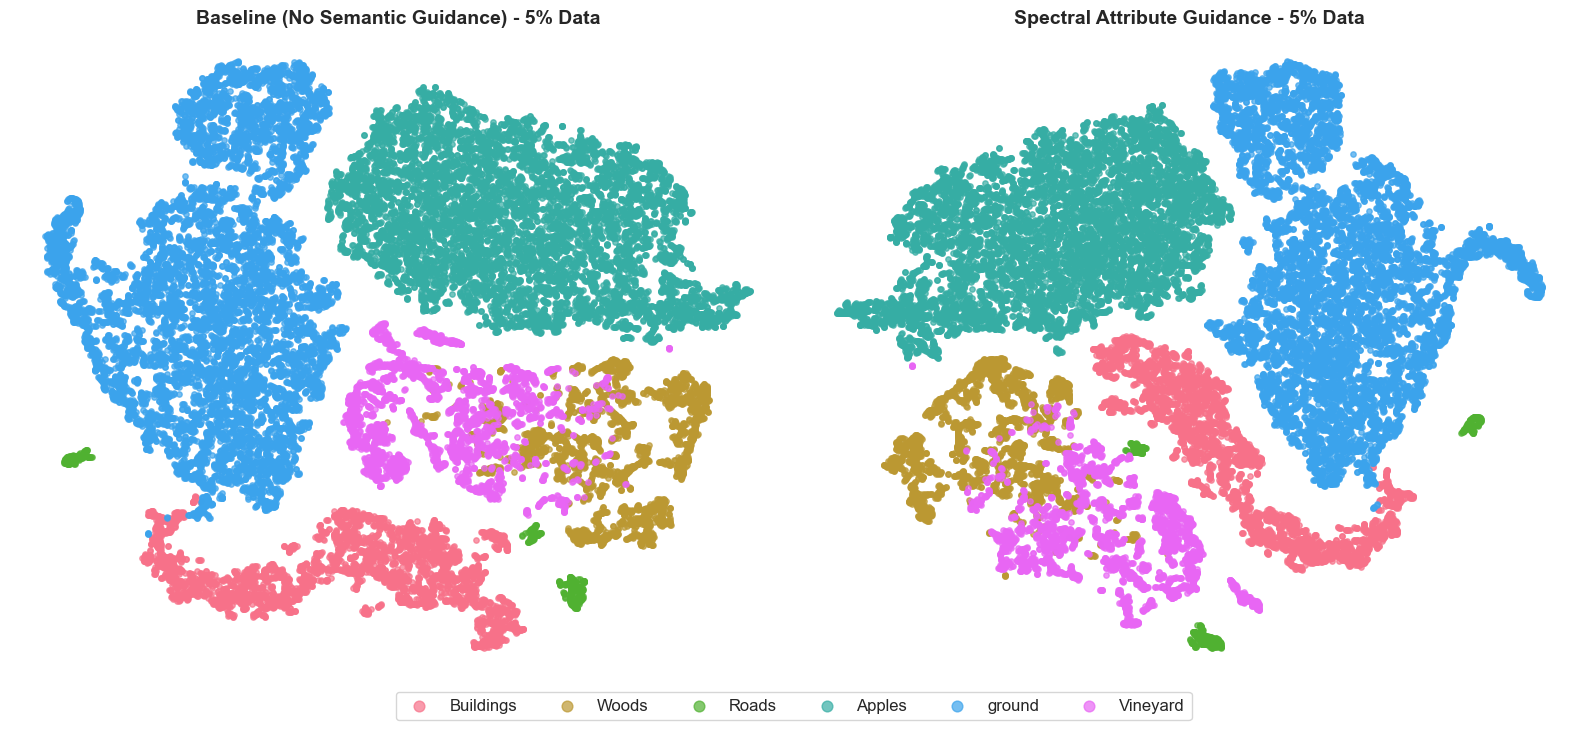

Extracting features for baseline_pct10_lam0.0...
Extracting features for spectral_pct10_lam0.03...
Running t-SNE algorithm (this usually takes 1-2 minutes)...


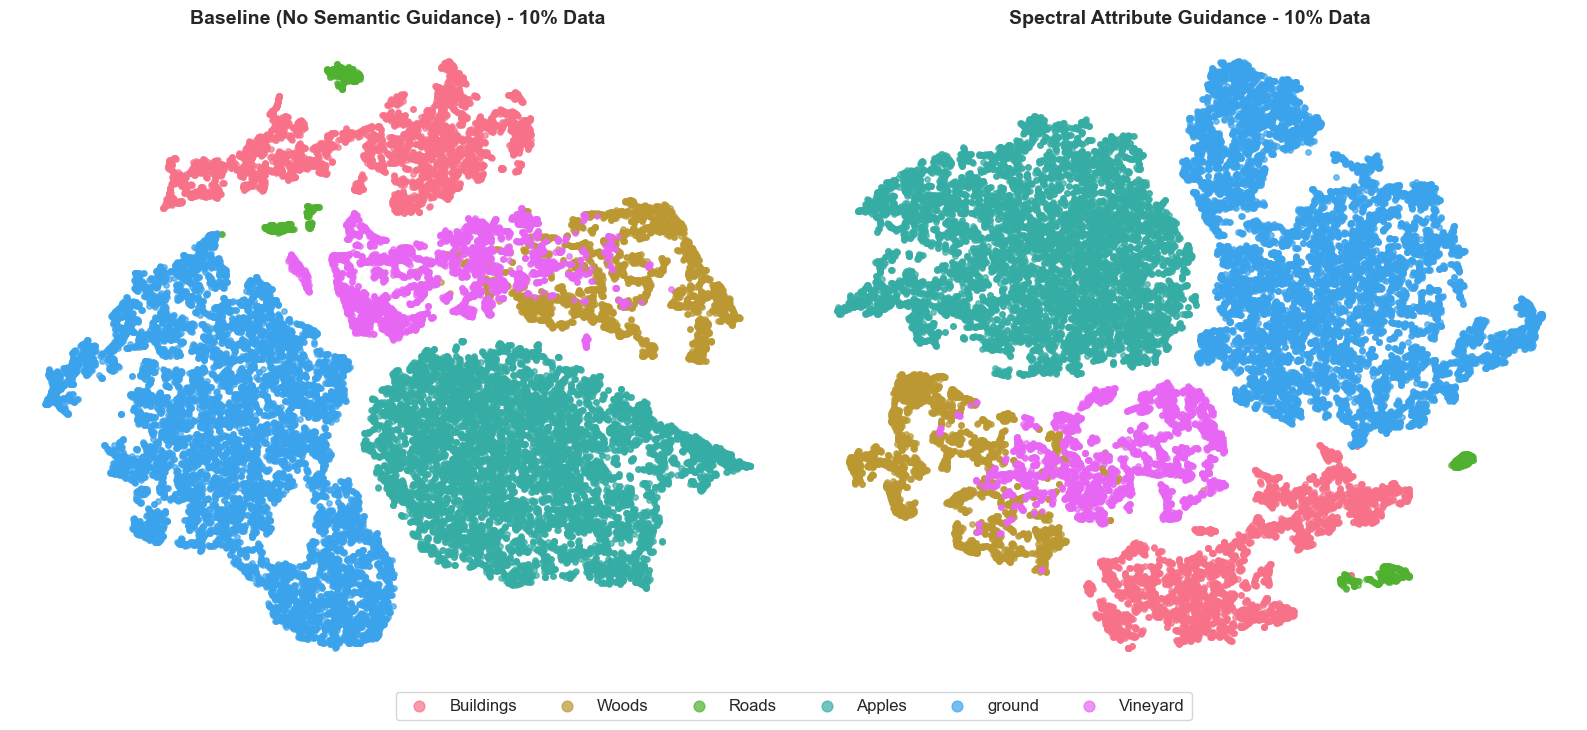

In [10]:

# %%



def extract_features(run_tag, dataset_name="Trento"):
    print(f"Extracting features for {run_tag}...")
    
    # Initialize a fresh model
    model = CrossHL_Transformer(FM=FM, NC=NC, NCLidar=NCLidar, Classes=Classes, patchsize=patchsize).to(device)
    
    #Load the trained weights
    weight_path = f"{dataset_name}/net_params_{FileName}_{run_tag}.pkl"
    if not os.path.exists(weight_path):
        print(f"File not found: {weight_path}")
        return None, None
        
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()
    
    all_features = []
    all_labels = []
    
    number = len(test_label) // test_batch_size
    with torch.no_grad():
        for i in range(number):
            temp_hsi = test_patch_hsi[i * test_batch_size:(i + 1) * test_batch_size].to(device)
            temp_ldr = test_patch_lidar[i * test_batch_size:(i + 1) * test_batch_size].to(device)
            temp_lbl = test_label[i * test_batch_size:(i + 1) * test_batch_size].cpu().numpy()
            
            # Get the embeddings (the second output from return_embed=True)
            _, img_embed = model(temp_hsi, temp_ldr, return_embed=True)
            all_features.append(img_embed.cpu().numpy())
            all_labels.append(temp_lbl)
            
        # Handle the remaining samples
        if (number * test_batch_size) < len(test_label):
            temp_hsi = test_patch_hsi[number * test_batch_size:].to(device)
            temp_ldr = test_patch_lidar[number * test_batch_size:].to(device)
            temp_lbl = test_label[number * test_batch_size:].cpu().numpy()
            
            _, img_embed = model(temp_hsi, temp_ldr, return_embed=True)
            all_features.append(img_embed.cpu().numpy())
            all_labels.append(temp_lbl)
            
    return np.concatenate(all_features, axis=0), np.concatenate(all_labels, axis=0)

def plot_tsne_comparison(pct_to_test=5):
    """
    Plots the baseline vs spectral features for a specific few-shot percentage.
    pct_to_test: 1, 5, or 10.
    """
    # Define the tags to compare 
    # If changed lambda to 0.1, change the "0.03" below to "0.1"!
    tag_baseline = f"baseline_pct{pct_to_test}_lam0.0"
    tag_spectral = f"spectral_pct{pct_to_test}_lam0.03" 
    
    # Extract features
    feat_base, labels_base = extract_features(tag_baseline)
    feat_spec, labels_spec = extract_features(tag_spectral)
    
    if feat_base is None or feat_spec is None:
        print("Cannot plot: missing models. Make sure training is finished.")
        return

    print("Running t-SNE algorithm (this usually takes 1-2 minutes)...")
    
    # Run t-SNE to reduce dimensions
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
    tsne_base = tsne.fit_transform(feat_base)
    tsne_spec = tsne.fit_transform(feat_spec)
    
    # Set up the plot aesthetics
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    palette = sns.color_palette("husl", Classes)
    
    # Plot Baseline
    for i in range(Classes):
        idx = labels_base == i
        axes[0].scatter(tsne_base[idx, 0], tsne_base[idx, 1], 
                        c=[palette[i]], label=class_names[i], alpha=0.7, s=15)
    axes[0].set_title(f"Baseline (No Semantic Guidance) - {pct_to_test}% Data", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Plot Spectral
    for i in range(Classes):
        idx = labels_spec == i
        axes[1].scatter(tsne_spec[idx, 0], tsne_spec[idx, 1], 
                        c=[palette[i]], label=class_names[i], alpha=0.7, s=15)
    axes[1].set_title(f"Spectral Attribute Guidance - {pct_to_test}% Data", fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Add a unified legend
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=Classes, fontsize=12, markerscale=2, bbox_to_anchor=(0.5, -0.05))
    
    plt.tight_layout()
    plt.savefig(f"tSNE_Comparison_pct{pct_to_test}.png", dpi=300, bbox_inches='tight')
    plt.show()


plot_tsne_comparison(pct_to_test=5)
plot_tsne_comparison(pct_to_test=10)